In [1]:
import numpy as np
import pandas as pd
import os
import torch
from utils.csv_to_pd import *
from utils.lstm_tool import *
import random

seed = 42

np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [2]:
def map_location_code(code):
    if code in {1, 2, 3, 4, 5, 6, 7}:
        return 0
    elif code in {8, 9}:
        return 1
    elif code in {10, 11, 12}:
        return 2
    elif code in {13, 14}:
        return 3
    elif code in {15, 16}:
        return 4
    elif code == 17:
        return 5
    else:
        return None

In [3]:

def get_full_9_17(df: pd.DataFrame) -> list[tuple[int, int, np.ndarray]]:
    """
    取得9點~17點
    每10分鐘都有資料的那幾天的發電量

    資料先後順序:
    location, month_day, label_np
    """

    location = df["LocationCode"].unique()
    used_train_data = []
    
    for l in location:
        l_df = df[df["LocationCode"] == l]
        month_day = l_df["month_day"].unique()
        all_day_count = 0
        use_count = 0
        for md in month_day:
            l_md_df = l_df[l_df["month_day"] == md]
            if len(l_md_df) == 48:
                used_train_data.append((int(l), int(md), np.array(l_md_df['Power(mW)'])))
                use_count += 1
            all_day_count += 1
        print(f"loc:{l}, {use_count}/{all_day_count}")
    return used_train_data

def get_data_label(df: pd.DataFrame, target_data: tuple):
    """
    根據target_data的location, month_day, label_np

    取得同個地點、日期所有9:00~17:00以前的數據紀錄

    回傳:
    資料長度、資料、標籤
    """


    location, month_day, label_np = target_data

    support_data = []
    for i in range(9, 17):
        for _ in range(6):
            support_data.append([map_location_code(location), int(month_day / 100) / 12, (i - 9) / 7])

    target_df = df[df["LocationCode"] == location].copy() 
    target_df = target_df[target_df["month_day"] == month_day]
    target_df = target_df.drop(columns=['month_day'])
    if len(target_df) == 0:
        return None
    #去除時間缺失過大的資料
    start = len(target_df) - 1
    end = len(target_df)

    if target_df.iloc[start]['DateTime'].hour == 8:
        while start > 0:
            start -= 1
            if target_df.iloc[start + 1]['DateTime'].hour - target_df.iloc[start + 1]['DateTime'].hour > 1:
                break
    if end - start < 6:
        return None


    target_df = target_df.drop(columns=['DateTime'])
    target_df["LocationCode"] = target_df["LocationCode"].apply(map_location_code)

    data = np.array(target_df)
    label = label_np

    
    return len(data), (data, support_data), label
def get_data_label_list(target_df, target_datas):
    feature_df = get_features(target_df)

    data_label_list = []
    data_label_list_index = 0

    location_month_class = []
    for i in range(18):
        location_month_class.append([])
        for _ in range(13):
            location_month_class[i].append([])



            

    for target_data in target_datas:
        data_label = get_data_label(feature_df, target_data)
        if data_label != None:
            data_label_list.append(data_label)
            location, month_day, _ = target_data
            location_month_class[location][month_day // 100].append(data_label_list_index)
            data_label_list_index += 1

    return data_label_list, location_month_class

def get_upload_data_list(target_df, target_datas):
    feature_df = get_features(target_df)
    
    data_list = []
    support_data_list = []

    for target_data in target_datas:
        data_label = get_data_label(feature_df, target_data)
        
        if data_label != None:
            _, data_tuple, _ = data_label
            data, support_data = data_tuple
            data_list.append(torch.from_numpy(np.array(data)))
            support_data_list.append(torch.from_numpy(np.array(support_data)))
    return data_list, support_data_list


def get_batch(data: list, support_data: list, label: list, batch_size=64):
    """
    將 data 跟 label 根據 batch_size 切成 batch，並用 batch 中最長的資料長度進行填充。
    填充的部分加在真實資料之前。
    """
    batch_datas = []
    batch_labels = []
    batch_support_data = []

    for i in range(0, len(data), batch_size):
        # 找到本 batch 中最長的序列長度
        max_length = len(data[min(i + batch_size, len(data)) - 1])
        
        # 填充每個序列
        batch_data = []
        for j in range(i, min(i + batch_size, len(data))):
            seq = data[j]
            pad_length = max_length - len(seq)
            padded_seq = [[0] * len(seq[0])] * pad_length
            padded_seq.extend(list(seq))
            batch_data.append(padded_seq)
        
        # 添加到 batch
        batch_datas.append(torch.tensor(batch_data, dtype=torch.float32))
        batch_support_data.append(torch.tensor(support_data[i:i + batch_size], dtype=torch.float32))
        batch_labels.append(torch.tensor(label[i:i + batch_size], dtype=torch.float32))

    return batch_datas, batch_support_data, batch_labels

def get_upload_target_list(path="36_TestSet_SubmissionTemplate/upload(no answer).csv"):
    """
    取得上傳答案所需的資料
    格式df, 需要處理的對象
    """

    upload = pd.read_csv(path)
    upload_target_set = set()
    upload_target_list = []
    for u_target in list(upload['序號']):
        month_day = int((u_target % 1e10) / 1e6)
        location = int(u_target % 100)
        if not month_day * 100 + location in upload_target_set:
            upload_target_set.add(month_day * 100 + location)
            upload_target_list.append((location, month_day, np.array(list(range(48)))))
    return upload, upload_target_list


def get_features(target_df: pd.DataFrame, before_time=9, start_time=4):
    feature_df_before = target_df[target_df['DateTime'].dt.hour < before_time]
    feature_df_before = feature_df_before[feature_df_before['DateTime'].dt.hour > start_time]

    return feature_df_before


def random_split_with_class(data_label_list, location_month_class, train_ratio=0.9):
    min_data_num = int(1 / (1 - train_ratio))

    train_indices = []
    valid_indices = []

    for i in range(1, 18):
        for j in range(1, 13):
            if len(location_month_class[i][j]) < min_data_num:
                train_indices.extend(location_month_class[i][j])
            else:
                random.shuffle(location_month_class[i][j])
                train_indices.extend(location_month_class[i][j][:int(len(location_month_class[i][j]) * train_ratio)])
                valid_indices.extend(location_month_class[i][j][int(len(location_month_class[i][j]) * train_ratio):])
    train_data_label_list = [data_label_list[i] for i in train_indices]
    valid_data_label_list = [data_label_list[i] for i in valid_indices]

    return train_data_label_list, valid_data_label_list


In [4]:
from sklearn.preprocessing import StandardScaler

#取得做完各種處理的dataframe
target_df = read_dir_csv()
target_df = mean_min(target_df, 10)
target_df['DateTime'] = pd.to_datetime(target_df['DateTime'])
target_df["month_day"] = target_df['DateTime'].dt.month * 100 + target_df['DateTime'].dt.day
target_df['month'] = target_df['DateTime'].dt.month
target_df['hour'] = target_df['DateTime'].dt.hour

copy_target_df = target_df.copy()

#取得所有可用的訓練資料 target_datas
after_9 = target_df[target_df['DateTime'].dt.hour >= 9].drop(columns=["WindSpeed(m/s)", "Pressure(hpa)", "Temperature(°C)", "Humidity(%)", "Sunlight(Lux)"])
between_9_17 = after_9[after_9['DateTime'].dt.hour < 17]
target_datas = get_full_9_17(between_9_17)

# 標準化
columns_to_standardize = ['WindSpeed(m/s)', 'Pressure(hpa)', 'Temperature(°C)', 'Humidity(%)', 'Sunlight(Lux)', "month", "Power(mW)", 'hour']
scaler = StandardScaler()
target_df[columns_to_standardize] = scaler.fit_transform(target_df[columns_to_standardize])



loc:10.0, 120/126
loc:11.0, 69/78
loc:12.0, 114/126
loc:13.0, 80/97
loc:14.0, 74/90
loc:15.0, 98/116
loc:16.0, 97/106
loc:17.0, 117/124
loc:1.0, 107/145
loc:2.0, 99/124
loc:3.0, 61/85
loc:4.0, 80/88
loc:5.0, 61/70
loc:6.0, 60/62
loc:7.0, 59/72
loc:8.0, 148/199
loc:9.0, 108/136


In [5]:
# 根據target_datas生成train和valid
data_label_list, location_month_class = get_data_label_list(target_df, target_datas)

In [6]:

train_data_label_list, valid_data_label_list = random_split_with_class(data_label_list, location_month_class, 0.92)
train_data_tuple, train_label, train_length = sort_by_length(train_data_label_list)
train_data, train_support_data = list(zip(*train_data_tuple))
valid_data_tuple, valid_label, valid_length = sort_by_length(valid_data_label_list)
valid_data, valid_support_data = list(zip(*valid_data_tuple))
print(len(train_data_label_list), len(valid_data_label_list))

1413 132


In [7]:
import torch
import torch.nn as nn

class LSTMTagger(nn.Module):

    def __init__(self, hidden_dim, tagset_size=1, input_dim=8, support_dim=3, cnn_out_channels=8):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        # Feature LSTM (直接處理輸入資料)
        self.feature_lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)

        # CNN 模塊
        self.conv1 = nn.Conv1d(input_dim, cnn_out_channels, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv1d(cnn_out_channels, cnn_out_channels * 2, kernel_size=3, stride=2, padding=1)

        # CNN LSTM (CNN + LSTM)
        self.cnn_lstm = nn.LSTM(cnn_out_channels * 2, hidden_dim, batch_first=True, dropout=0.5)

        # Output LSTM (兩層)
        self.output_lstm = nn.LSTM(support_dim, hidden_dim, batch_first=True, num_layers=2, dropout=0.6)

        # 線性層
        self.linear = nn.Linear(hidden_dim, tagset_size)
        self.relu = nn.ReLU()
        self.cnn_dropout = nn.Dropout(0.5)

    def init_hidden(self, batch_size, num_layers=1):
        # 初始化隱藏狀態和細胞狀態
        return (torch.zeros(num_layers, batch_size, self.hidden_dim),
                torch.zeros(num_layers, batch_size, self.hidden_dim))

    def forward(self, data, support, hidden):
        """
        data: Tensor, shape (batch_size, seq_len, input_dim)
        support: Tensor, shape (batch_size, seq_len, support_dim)
        hidden: Initial hidden state

        Returns:
            tag_space: Tensor, shape (batch_size, tagset_size)
            hidden: Final hidden state
        """
        # Feature LSTM
        _, hidden_feature = self.feature_lstm(data, hidden)  # 提取全局特徵 (batch_size, seq_len, hidden_dim)

        # CNN + LSTM
        x = data.permute(0, 2, 1)  # (batch_size, input_dim, seq_len)
        x = torch.relu(self.conv1(x))
        x = self.cnn_dropout(x)
        x = torch.relu(self.conv2(x))  # (batch_size, cnn_out_channels, reduced_seq_len)
        x = self.cnn_dropout(x)
        x = x.permute(0, 2, 1)  # (batch_size, reduced_seq_len, cnn_out_channels)
        _, hidden_cnn = self.cnn_lstm(x, hidden)  # 提取局部特徵後的全局模式

        # 合併兩個 LSTM 的隱藏狀態
        combined_hidden = torch.cat([hidden_feature[0], hidden_cnn[0]], dim=0)  # (1, batch_size, 2 * hidden_dim)
        combined_cell = torch.cat([hidden_feature[1], hidden_cnn[1]], dim=0)
        


        # 擴展 Support 並進行 Output LSTM
        output, (hidden_out, cell_out) = self.output_lstm(support, (combined_hidden, combined_cell))

        # 線性層和激活函數
        tag_space = self.relu(self.linear(self.relu(output)))

        return tag_space, (hidden_out, cell_out)

In [8]:
# import os
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
# import torch
# import torch.nn as nn

# class LSTMTagger(nn.Module):

#     def __init__(self, hidden_dim, tagset_size=1, input_dim=8, support_dim=3):
#         super(LSTMTagger, self).__init__()
#         self.hidden_dim = hidden_dim

#         # LSTM層
#         self.feature_lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, dropout=0.4)
#         self.output_lstm = nn.LSTM(support_dim, hidden_dim, batch_first=True, dropout=0.4)


#         # 線性層
#         self.linear = nn.Linear(hidden_dim, tagset_size)
#         self.relu = nn.ReLU()

#     def init_hidden(self, batch_size):
#         # 初始化隱藏狀態和細胞狀態
#         return (torch.zeros(1, batch_size, self.hidden_dim),
#                 torch.zeros(1, batch_size, self.hidden_dim))

#     def forward(self, data, support, hidden):
#         """
#         sentence: Tensor, shape (batch_size, seq_len, input_dim)
#         hidden: Initial hidden state

#         Returns:
#             tag_space: Tensor, shape (batch_size, tagset_size)
#             hidden: Final hidden state
#         """
#         # LSTM層
#         _, hidden = self.feature_lstm(data, hidden)

#         output, hidden = self.output_lstm(support, hidden)

#         # 線性層和激活函數
#         tag_space = self.relu(self.linear(self.relu(output)))

#         return tag_space, hidden

In [9]:
import torch.optim as optim

# 設置 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定義訓練函數
def train_model(model, train_loader, valid_loader, num_epochs=10, learning_rate=0.001, log=True, save_best_model=True):
    # 將模型移到 GPU
    model = model.to(device, dtype=torch.float32)
    # 使用 Adam 優化器
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # 定義損失函數
    criterion = nn.SmoothL1Loss()
    min_loss = 1e9

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for inputs, support_datas, labels in train_loader:
            # 將輸入和標籤移到 GPU
            inputs, support_datas, labels = inputs.to(device, dtype=torch.float32), support_datas.to(device, dtype=torch.float32), labels.to(device, dtype=torch.float32)
            
            # 初始化隱藏狀態
            hidden = model.init_hidden(batch_size=inputs.size(0))
            hidden = tuple([h.to(device, dtype=torch.float32) for h in hidden])

            # 清零梯度
            optimizer.zero_grad()
            # 前向傳播
            outputs, _ = model(inputs, support_datas, hidden)

            # 計算損失
            loss = criterion(outputs.squeeze(), labels.squeeze())
            # 反向傳播
            loss.backward()
            # 更新參數
            optimizer.step()

            train_loss += loss.item()

        

        # 驗證模型
        valid_loss, valid_error  = validate_model(model, valid_loader, criterion)
        
        if valid_loss < min_loss and log:
            min_loss = valid_loss
            torch.save(model.state_dict(), "checkpoint.pth" )
            print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss / len(train_loader):.4f}")
            print(f"valid_loss:{valid_loss}, valid_error:{valid_error}")
    return min_loss


# 定義驗證函數
def validate_model(model, valid_loader, criterion):
    model.eval()
    total_loss = 0.0
    error = 0
    MAE_loss = nn.L1Loss()

    count = 0

    with torch.no_grad():
        for inputs, support_datas, labels in valid_loader:
            # 將輸入和標籤移到 GPU
            inputs, support_datas, labels = inputs.to(device, dtype=torch.float32), support_datas.to(device, dtype=torch.float32), labels.to(device, dtype=torch.float32)
            
            # 初始化隱藏狀態
            hidden = model.init_hidden(batch_size=inputs.size(0))
            hidden = tuple([h.to(device, dtype=torch.float32) for h in hidden])

            # 前向傳播
            outputs, _ = model(inputs, support_datas, hidden)
            # 計算損失
            loss = criterion(outputs.squeeze(), labels.squeeze())
            error += MAE_loss(outputs.squeeze(), labels.squeeze()).item() * labels.shape[0] * labels.shape[1]
            total_loss += loss.item() * labels.shape[0] * labels.shape[1]
            count += labels.shape[0] * labels.shape[1]

    return total_loss / count, error / count


In [10]:
# param_bounds = [(32, 64), #batch
#                 (128, 256), #hidden
#                 (0.001, 0.005) #lr
#                 ]

# num_wolves = 5
# max_iter = 20
# wolves = np.random.uniform(
#     [b[0] for b in param_bounds],
#     [b[1] for b in param_bounds],
#     size=(num_wolves, len(param_bounds))
# )

# def objective_function(wolf):
#     batch, hidden_dim, lr = int(wolf[0]), int(wolf[1]), wolf[2]
#     batch_train_data, batch_train_support_data, batch_train_label = get_batch(train_data, train_support_data, train_label, batch)
#     batch_valid_data, batch_valid_support_data, batch_valid_label = get_batch(valid_data, valid_support_data, valid_label, batch)
#     train_loader = list(zip(batch_train_data, batch_train_support_data, batch_train_label))
#     valid_loader = list(zip(batch_valid_data, batch_valid_support_data, batch_valid_label))
    
#     model = LSTMTagger(hidden_dim, 1, input_dim=train_data[0].shape[1])
#     return train_model(model, train_loader, valid_loader, num_epochs=1000, learning_rate=lr, log=False, save_best_model=False)

# alpha, beta, delta = wolves[0], wolves[1], wolves[2]

# for iteration in range(max_iter):
#     fitness = np.array([objective_function(wolf) for wolf in wolves])
#     sorted_indices = np.argsort(fitness)
#     alpha, beta, delta = wolves[sorted_indices[:3]]  # 選出 α, β, δ 狼

#     # 更新其餘狼的位置
#     for i in range(num_wolves):
#         for j in range(len(param_bounds)):
#             A = 2 * np.random.random() - 1  # 控制包圍半徑
#             C = 2 * np.random.random()     # 控制探索範圍
#             D_alpha = abs(C * alpha[j] - wolves[i, j])
#             X1 = alpha[j] - A * D_alpha

#             D_beta = abs(C * beta[j] - wolves[i, j])
#             X2 = beta[j] - A * D_beta

#             D_delta = abs(C * delta[j] - wolves[i, j])
#             X3 = delta[j] - A * D_delta

#             wolves[i, j] = (X1 + X2 + X3) / 3

#         # 確保參數在範圍內
#         wolves[i] = np.clip(wolves[i], [b[0] for b in param_bounds], [b[1] for b in param_bounds])

#     print(f"alpha: batch: {int(alpha[0])}, hidden: {int(alpha[1])}, lr: {alpha[2]}")
#     print(fitness[sorted_indices[0]])


# print(alpha)

In [11]:
batch = 64
batch_train_data, batch_train_support_data, batch_train_label = get_batch(train_data, train_support_data, train_label, batch)
batch_valid_data, batch_valid_support_data, batch_valid_label = get_batch(valid_data, valid_support_data, valid_label, batch)
train_loader = list(zip(batch_train_data, batch_train_support_data, batch_train_label))
valid_loader = list(zip(batch_valid_data, batch_valid_support_data, batch_valid_label))


C:\Users\weiso131\AppData\Local\Temp\ipykernel_46428\501150641.py:137: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  batch_datas.append(torch.tensor(batch_data, dtype=torch.float32))


In [12]:
model = LSTMTagger(128, 1, input_dim=train_data[0].shape[1])

train_model(model, train_loader, valid_loader, 2000, learning_rate=0.005)


c:\Users\weiso131\anaconda3\envs\AI\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [1/2000], Training Loss: 383.4064
valid_loss:351.98740271366006, valid_error:352.4805205374053
Epoch [2/2000], Training Loss: 379.5330
valid_loss:349.6130380341501, valid_error:350.10994096235794
Epoch [3/2000], Training Loss: 377.2816
valid_loss:348.1684459339489, valid_error:348.6660119258996
Epoch [4/2000], Training Loss: 375.6324
valid_loss:346.9788522431345, valid_error:347.4768417820786
Epoch [5/2000], Training Loss: 374.1302
valid_loss:346.176074403705, valid_error:346.67481208570075
Epoch [6/2000], Training Loss: 373.1851
valid_loss:345.7357140743371, valid_error:346.2339976917614
Epoch [7/2000], Training Loss: 372.6424
valid_loss:345.4560380415483, valid_error:345.95475537849194
Epoch [8/2000], Training Loss: 372.2466
valid_loss:345.45039321437025, valid_error:345.9493796608665
Epoch [9/2000], Training Loss: 371.9316
valid_loss:345.2069794625947, valid_error:345.70604543974906
Epoch [10/2000], Training Loss: 371.6552
valid_loss:345.140243992661, valid_error:345.639023289

KeyboardInterrupt: 

In [13]:
check_point = torch.load("checkpoint.pth")
model = LSTMTagger(128, 1, input_dim=train_data[0].shape[1])
model.load_state_dict(check_point)
model = model.to('cuda', dtype=torch.float32)


In [14]:
validate_model(model, valid_loader, nn.SmoothL1Loss())

(152.5724089651397, 153.06562666459516)

(64, 48) (64, 48)
torch.Size([64, 48, 3])


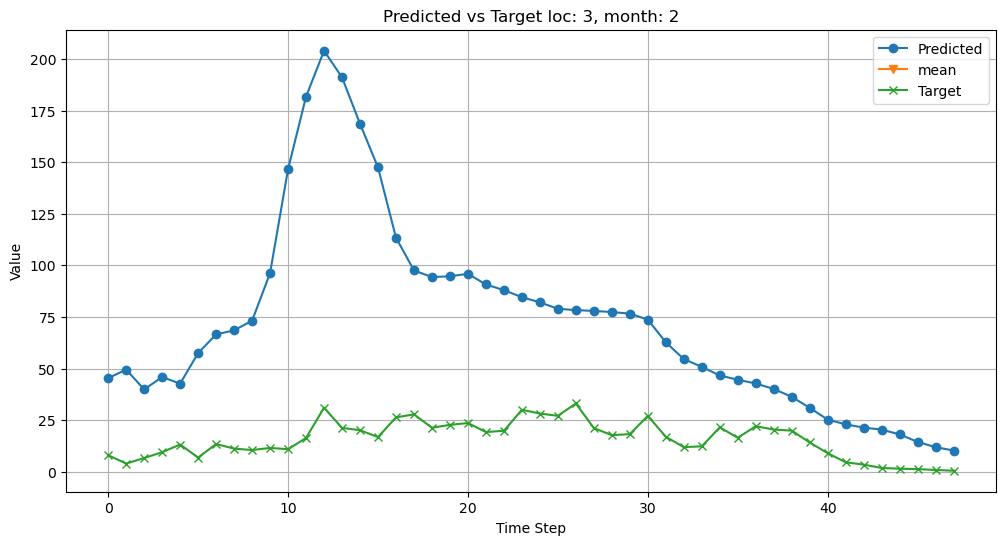

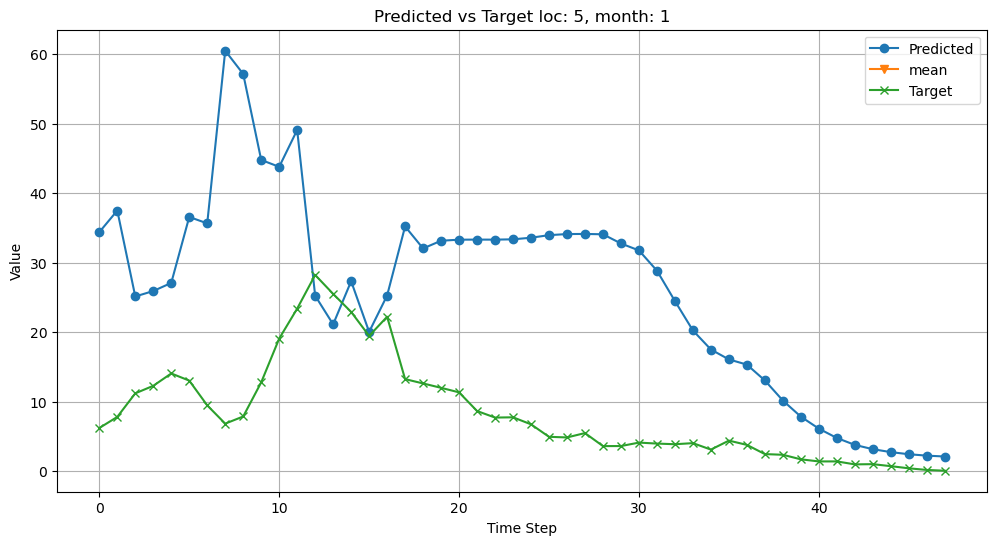

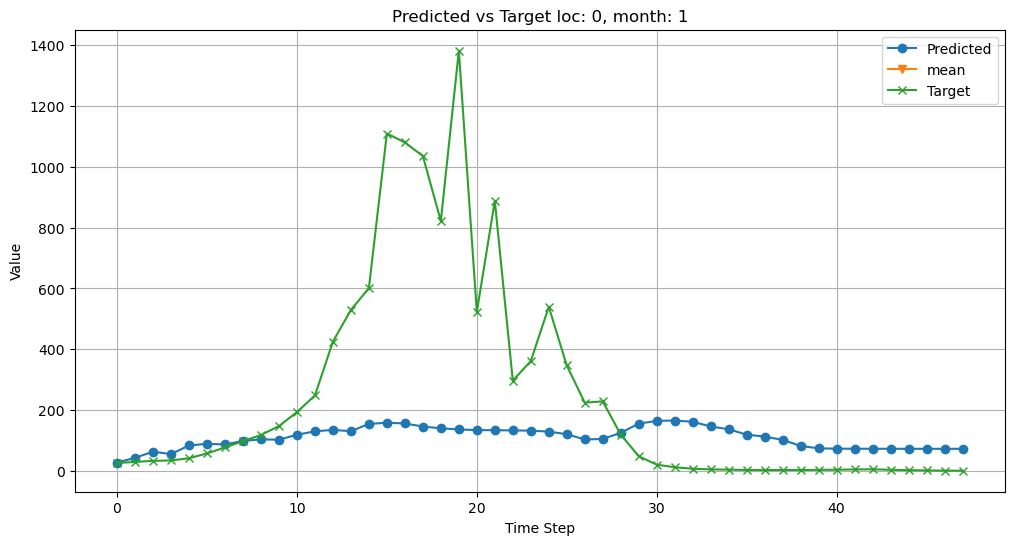

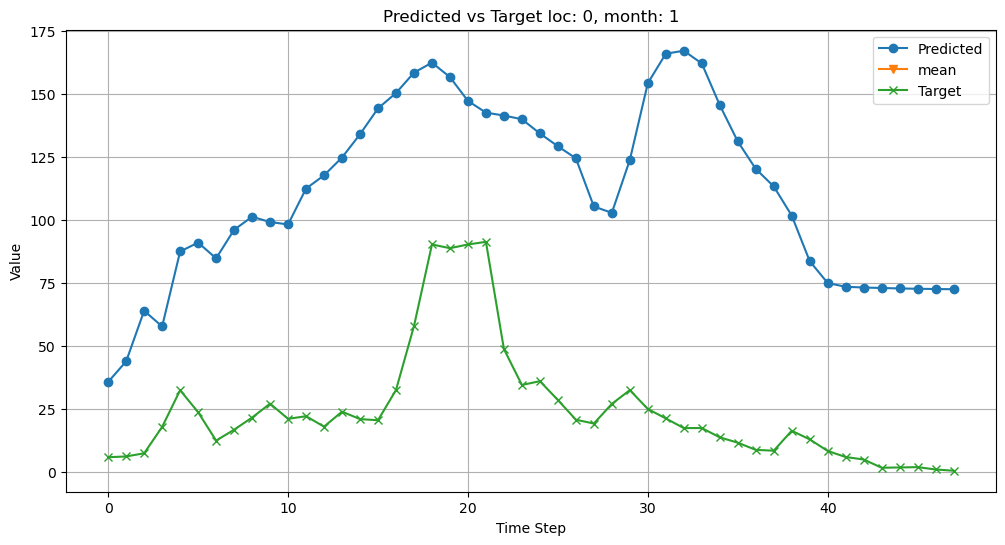

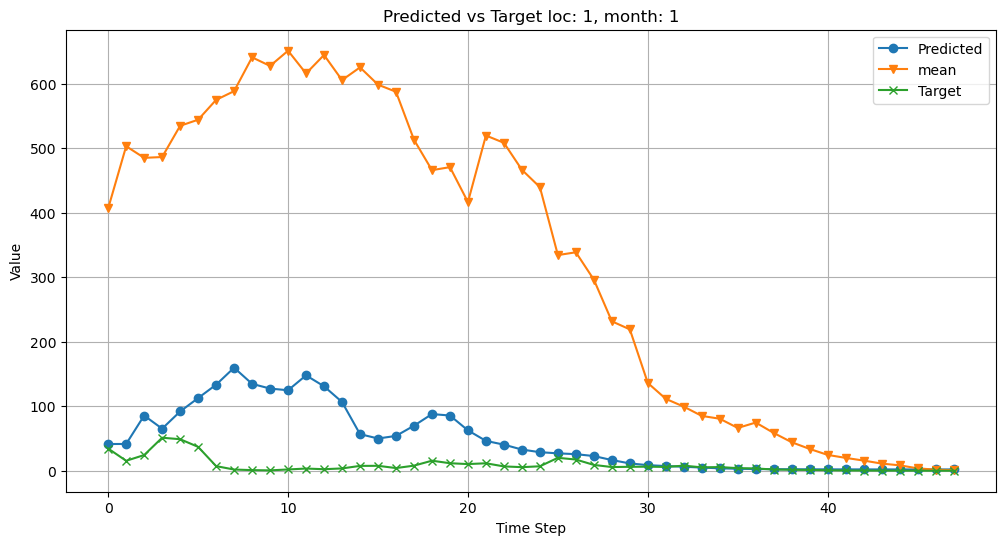

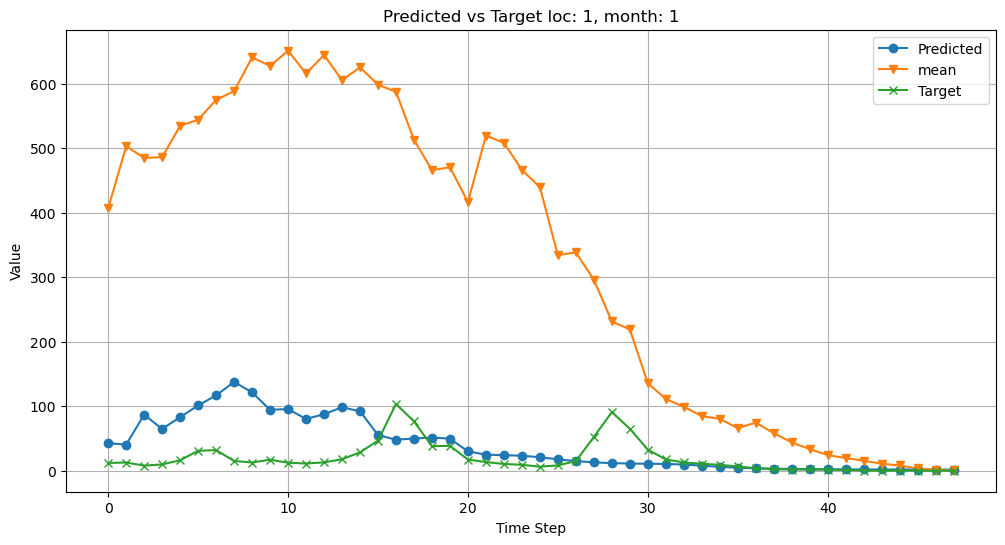

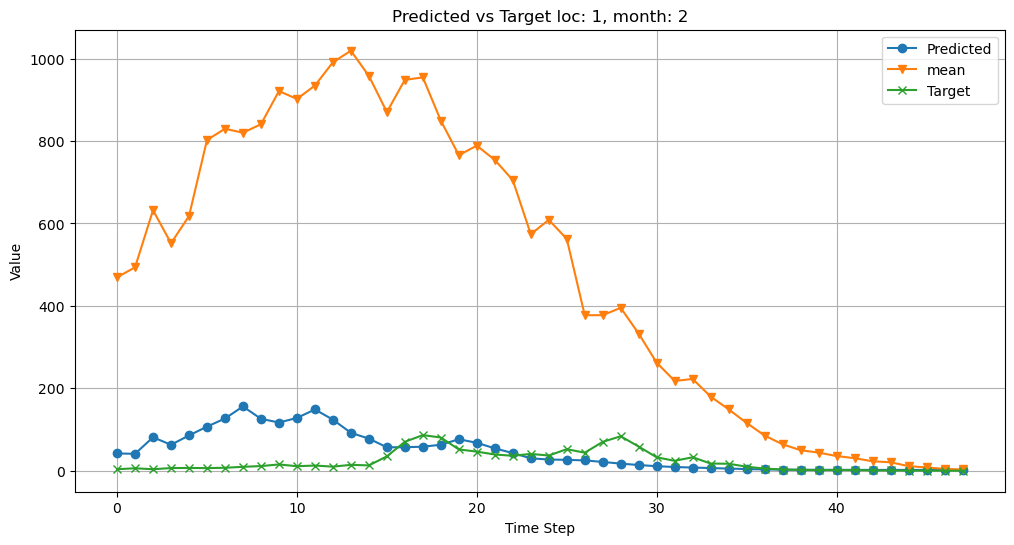

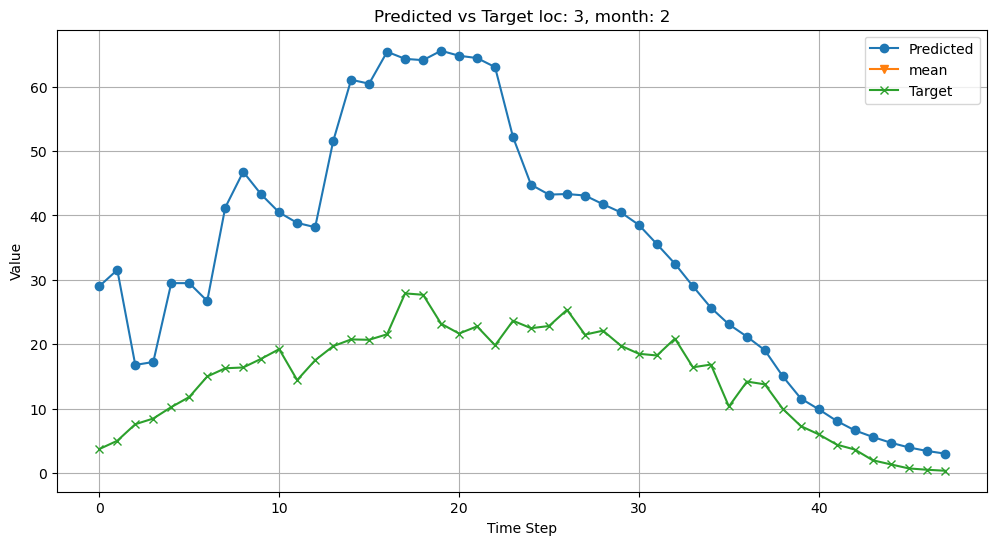

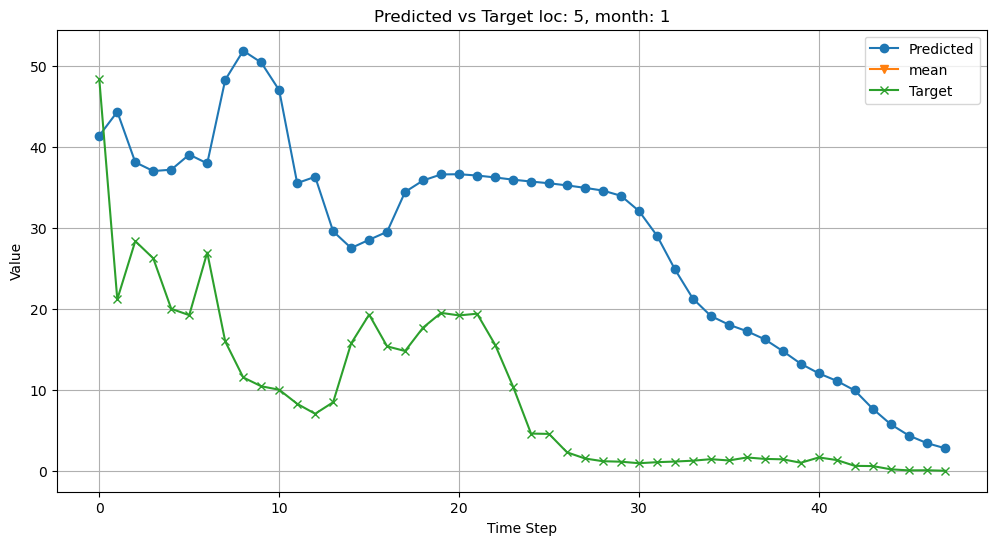

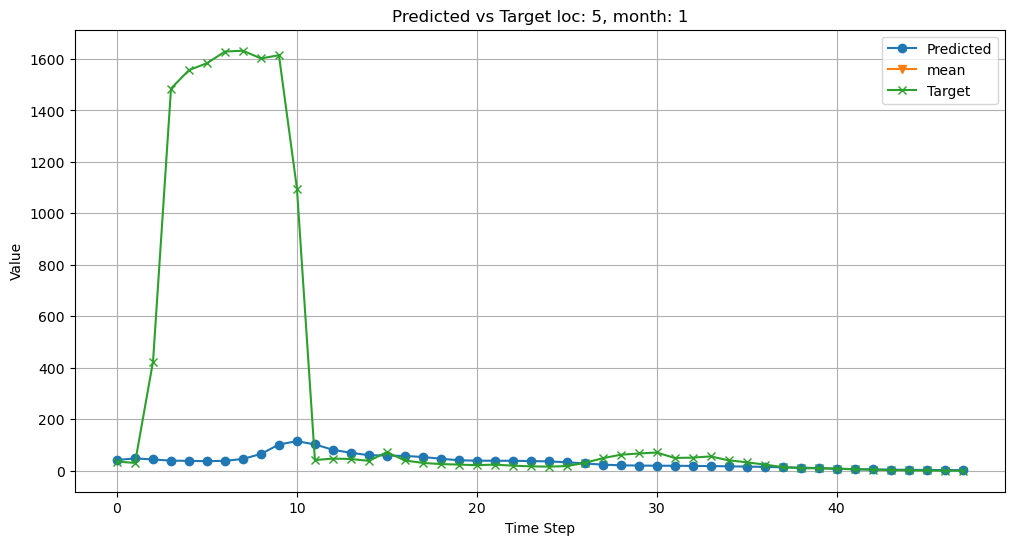

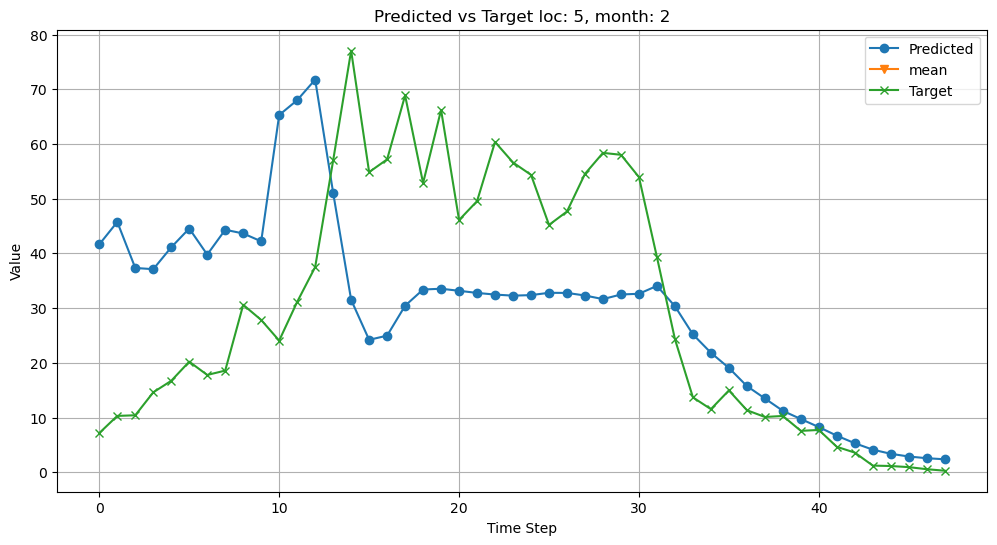

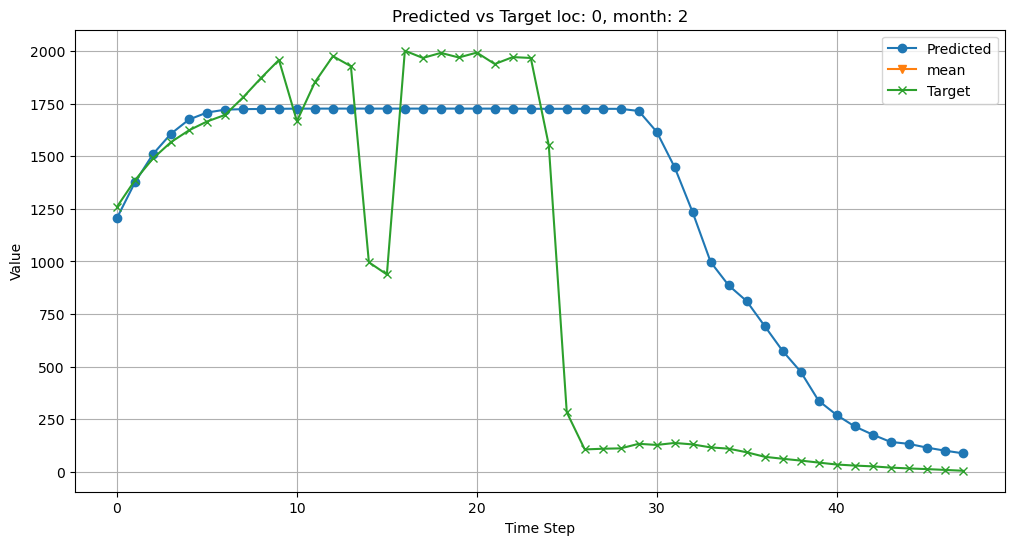

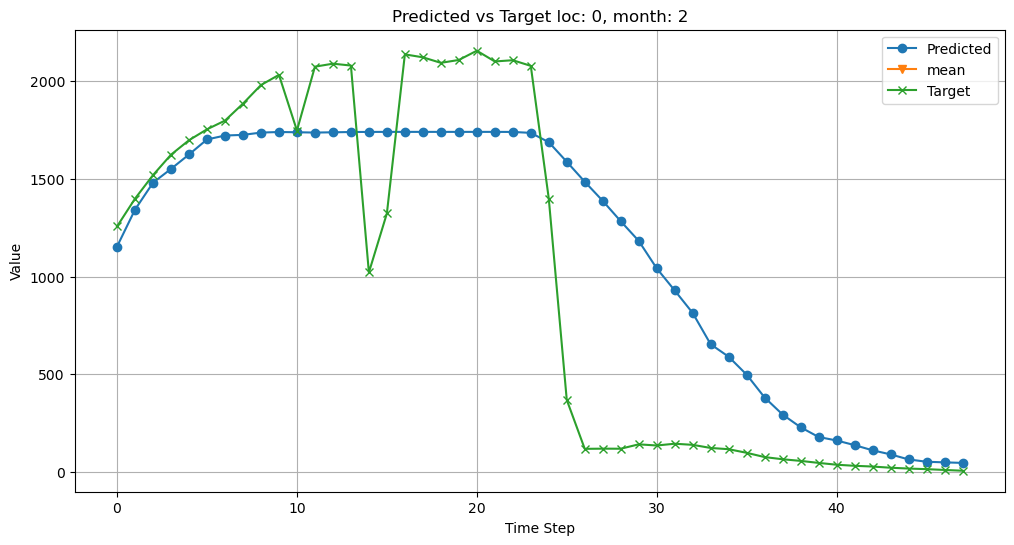

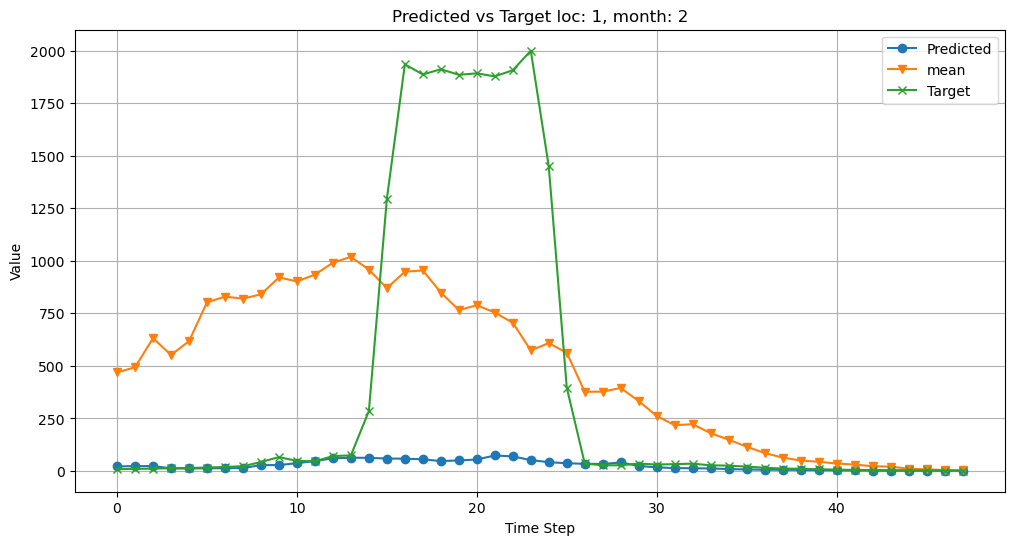

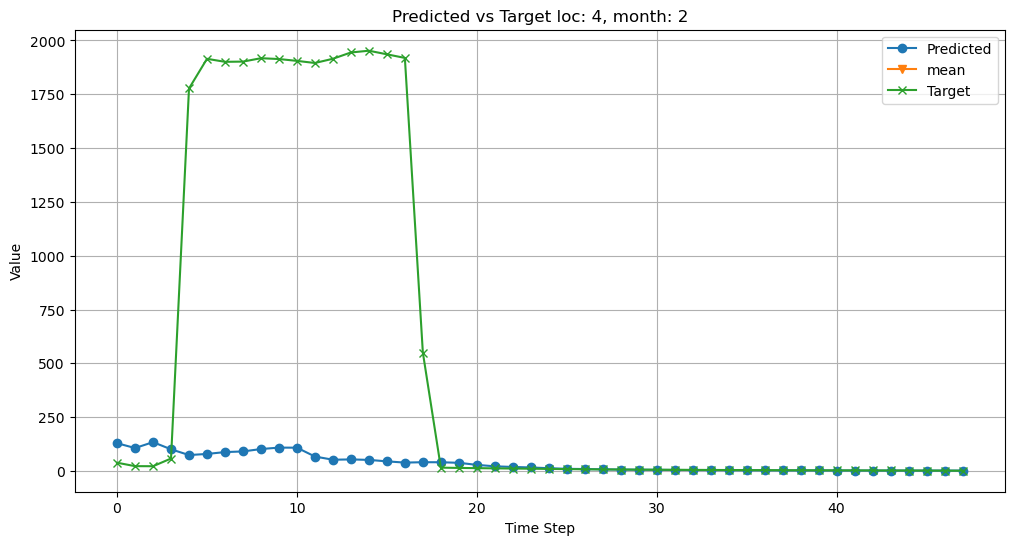

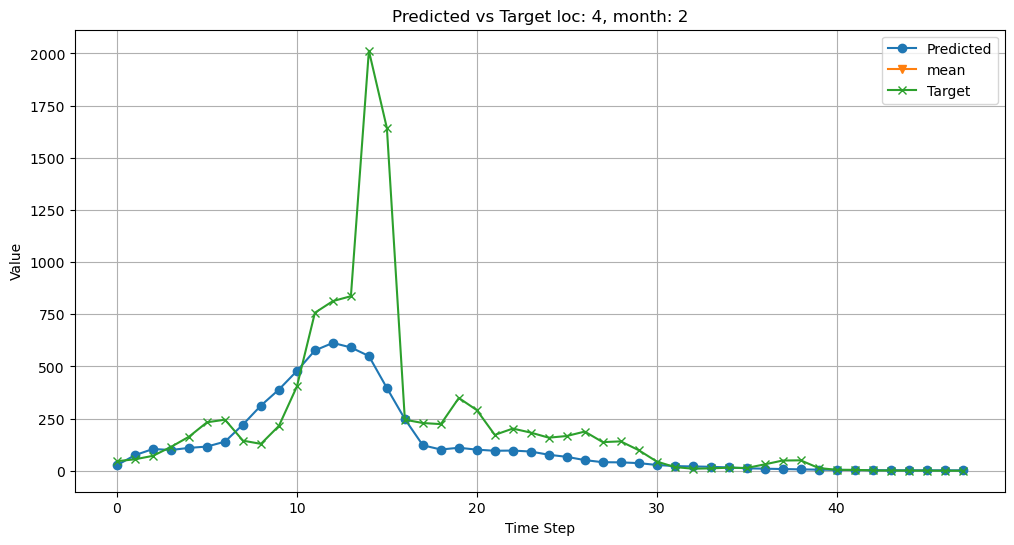

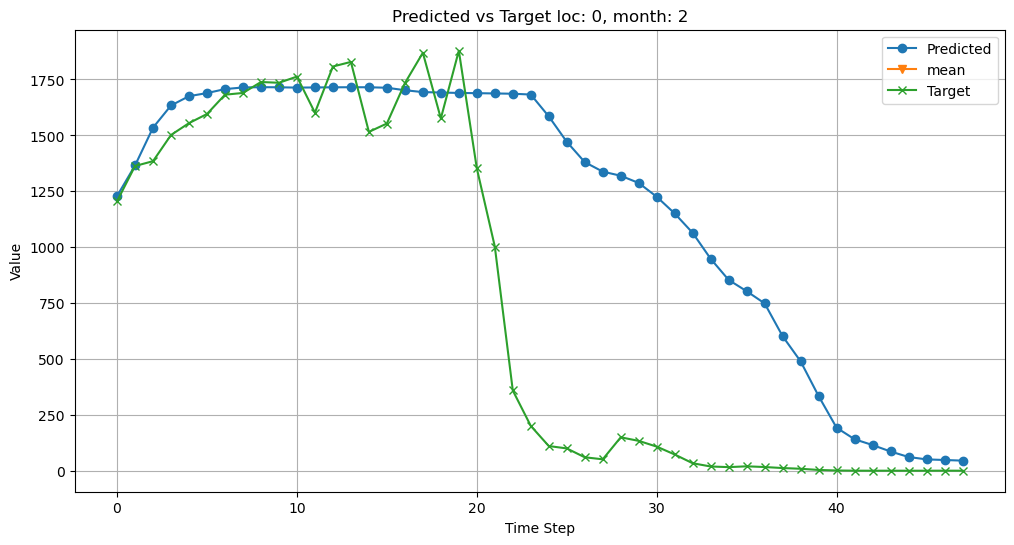

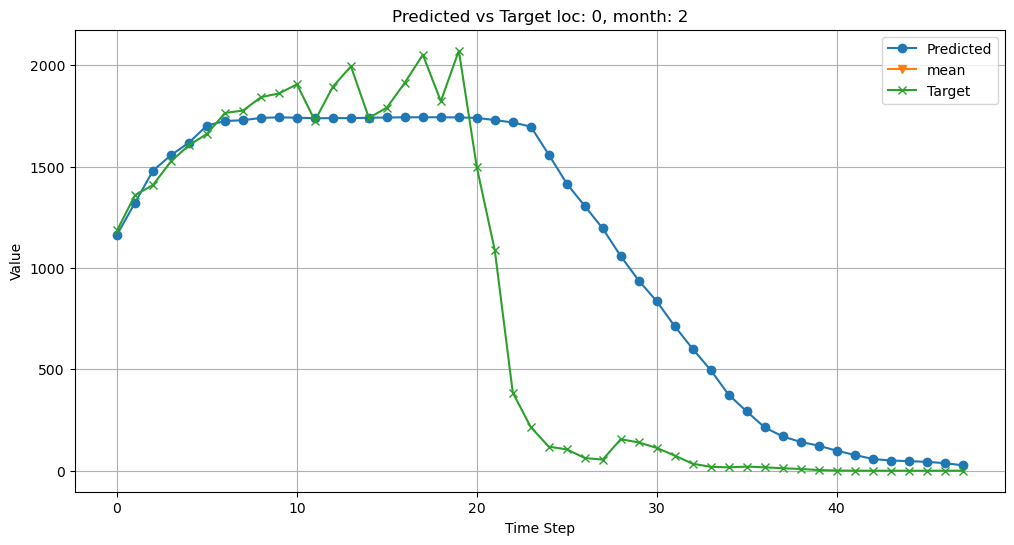

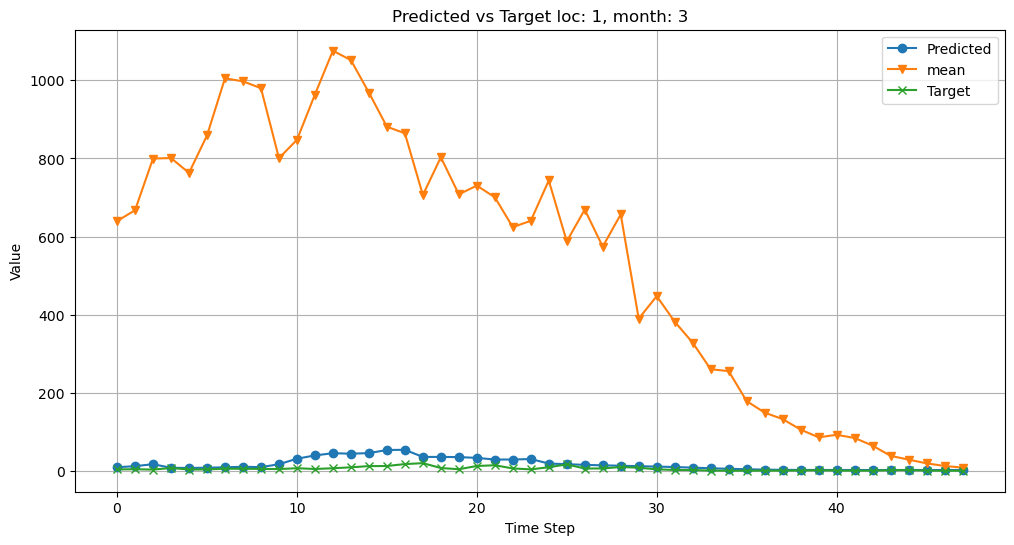

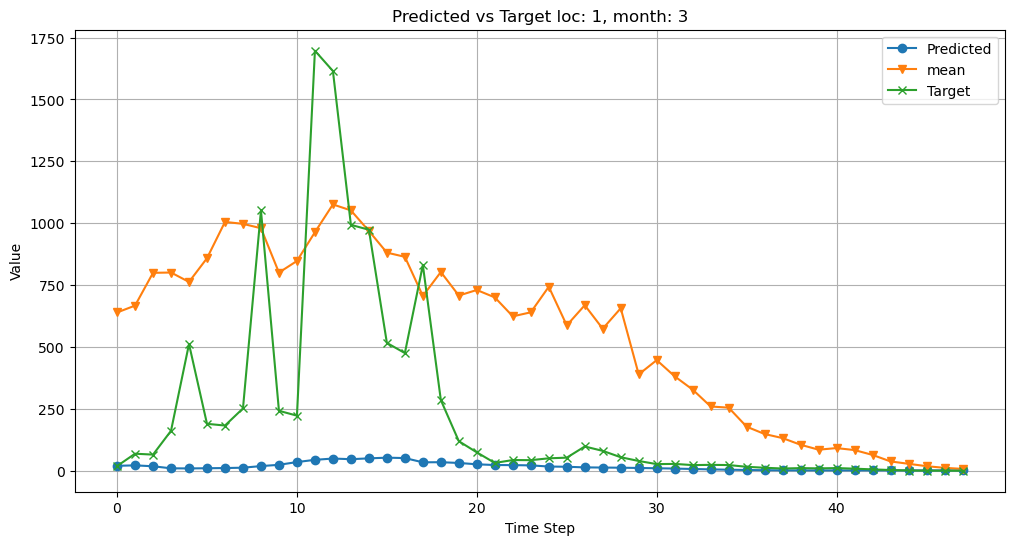

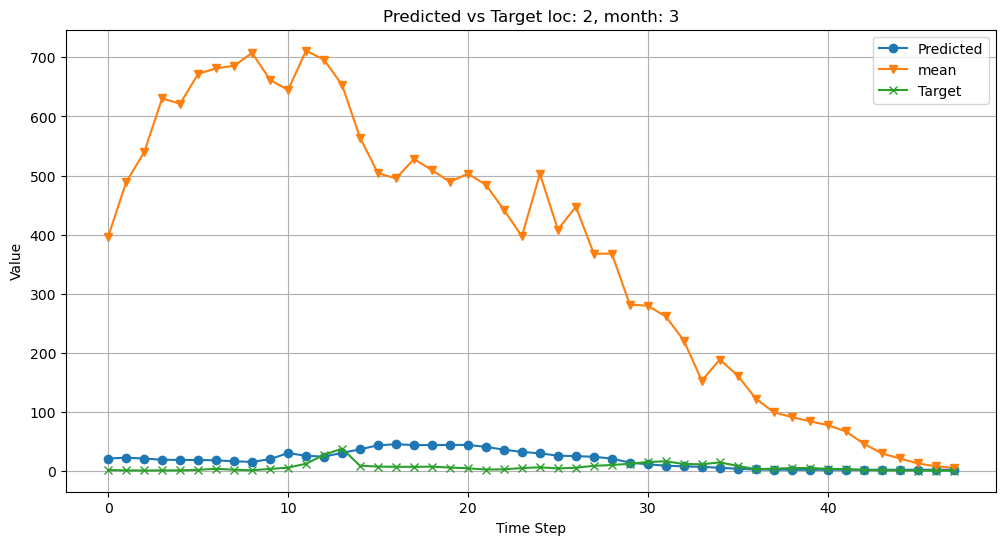

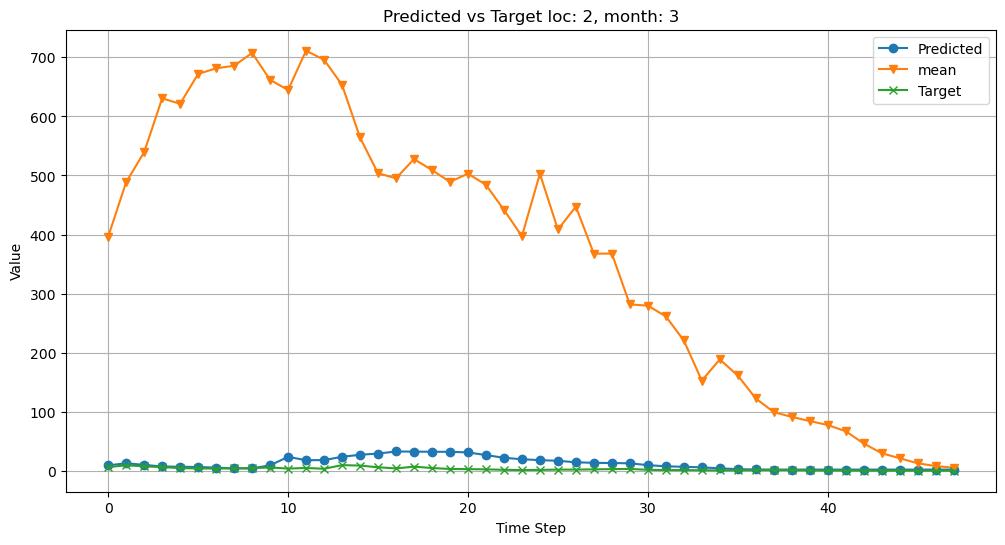

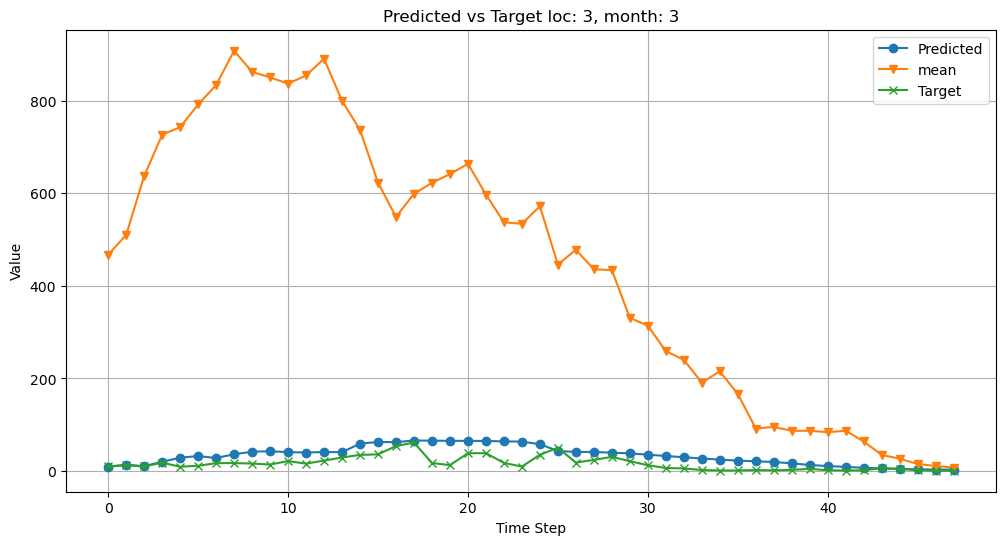

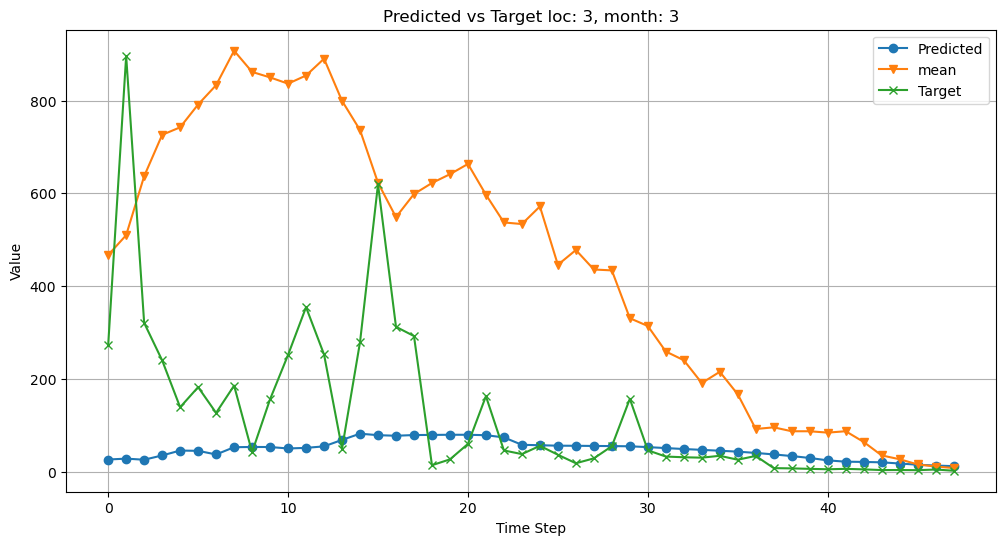

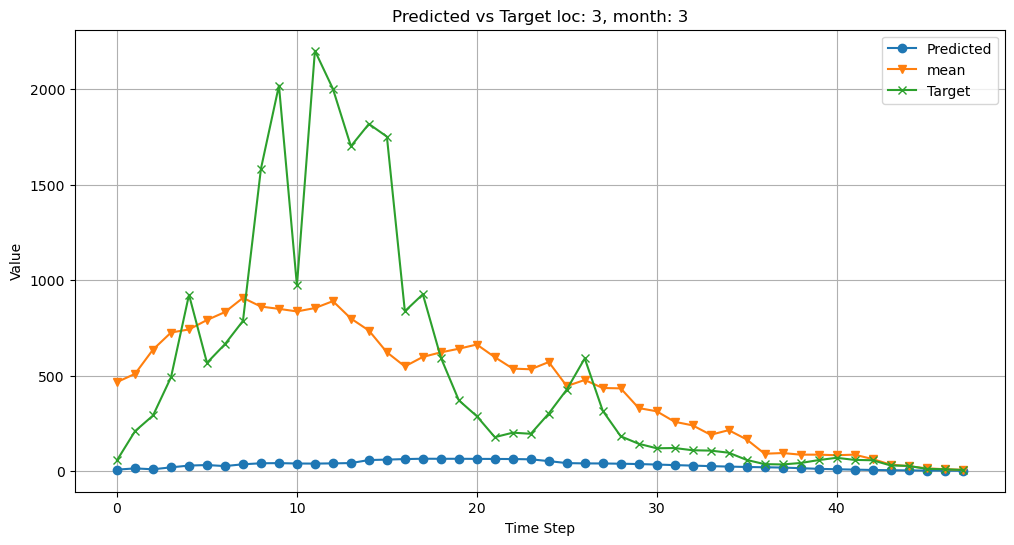

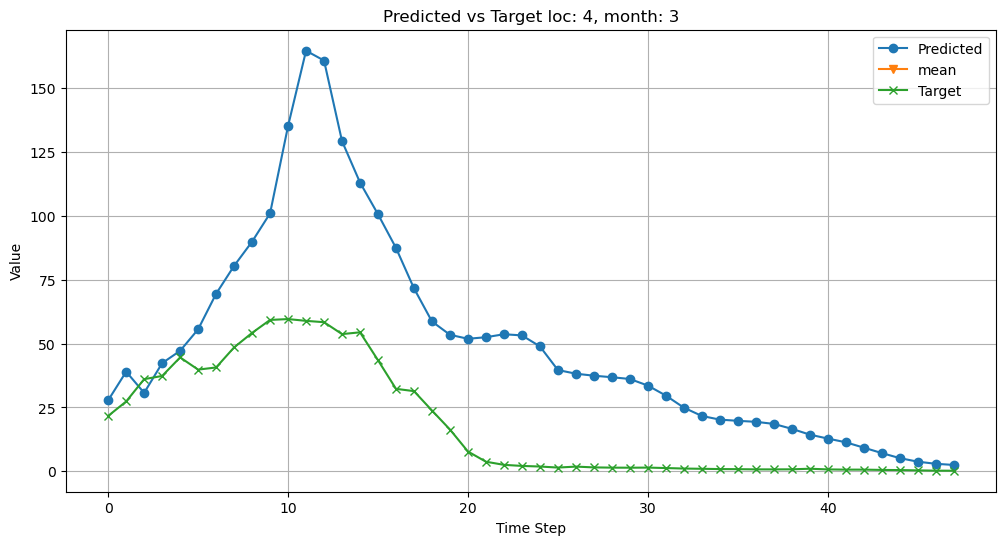

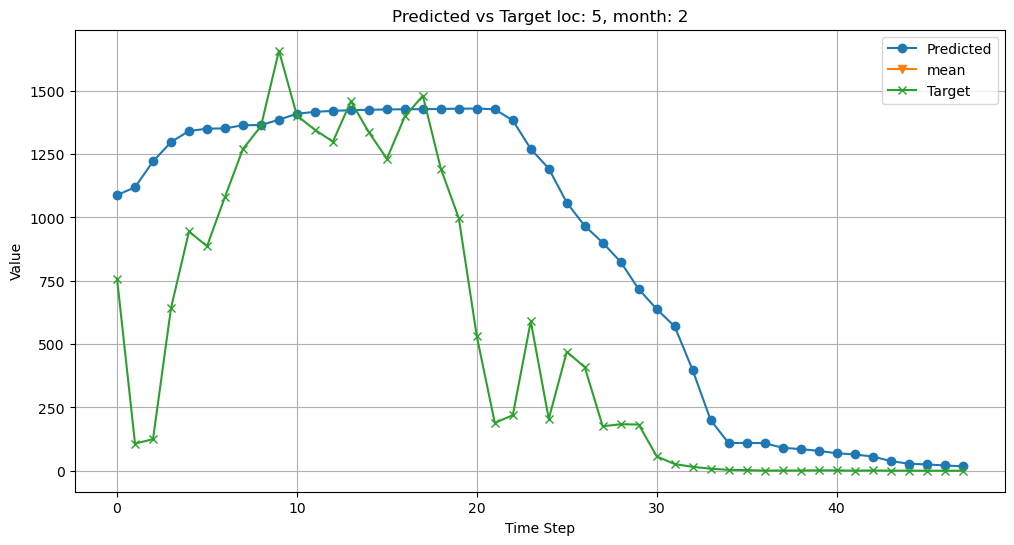

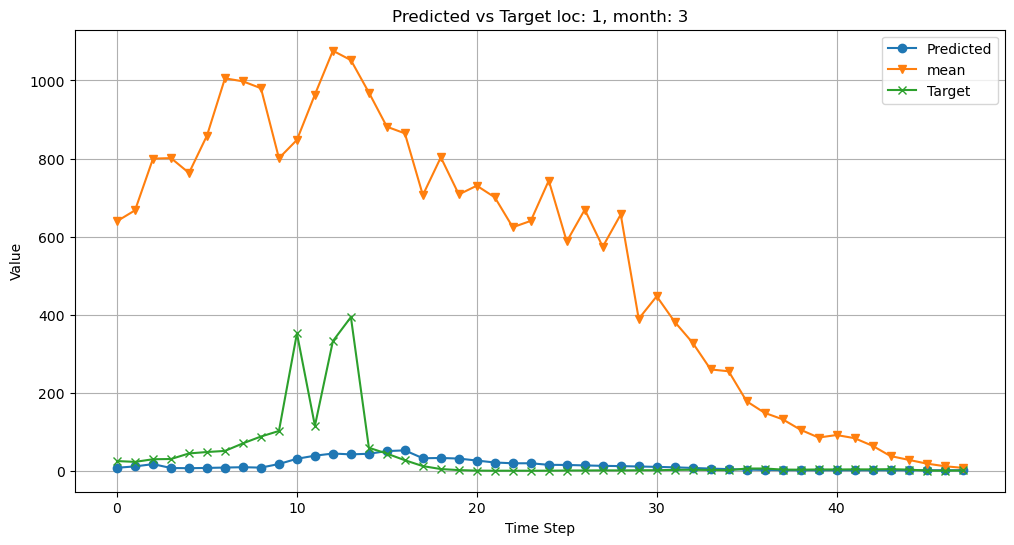

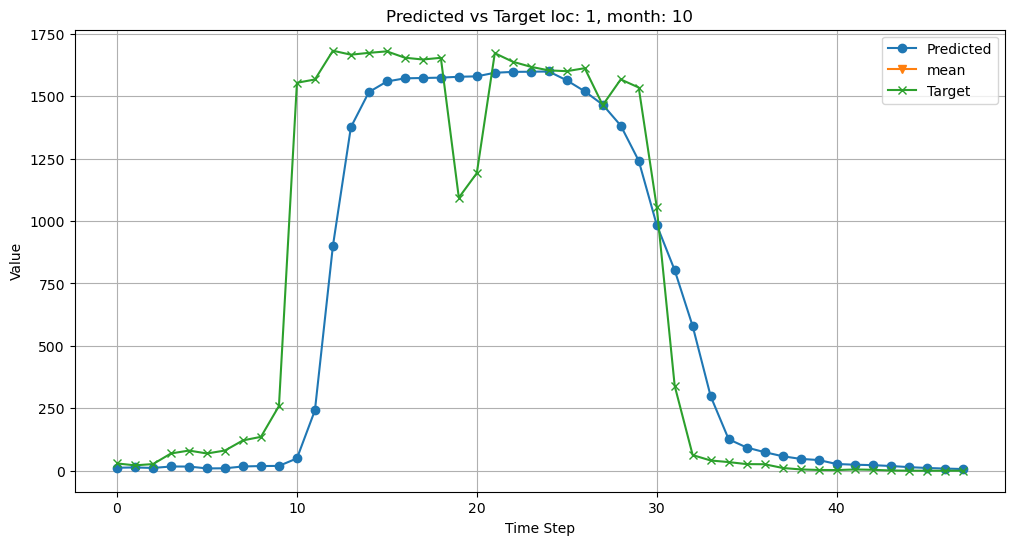

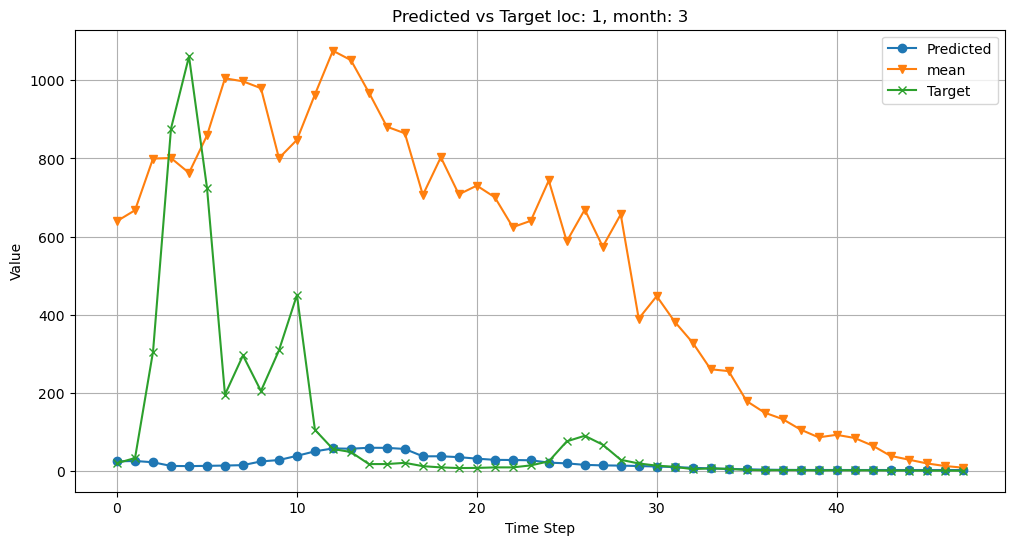

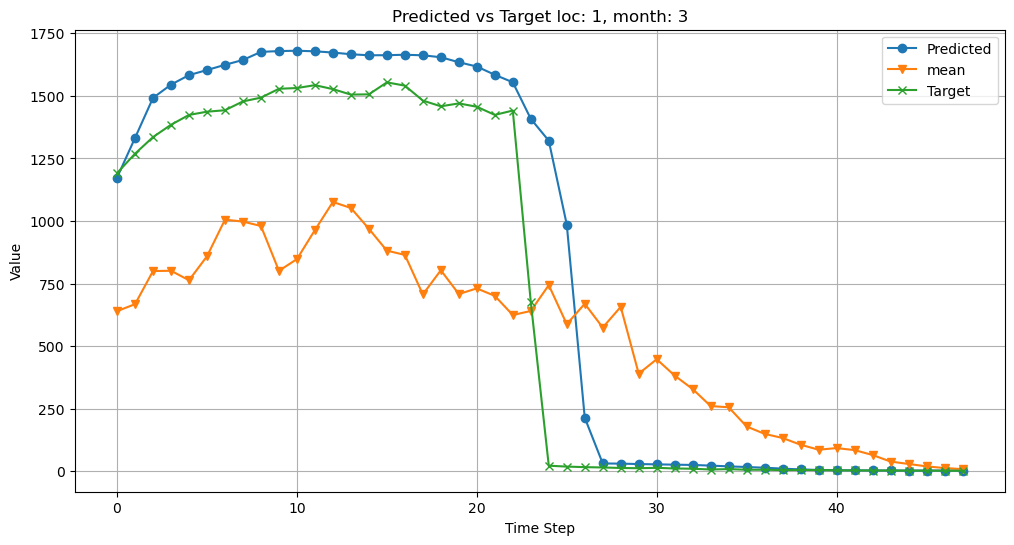

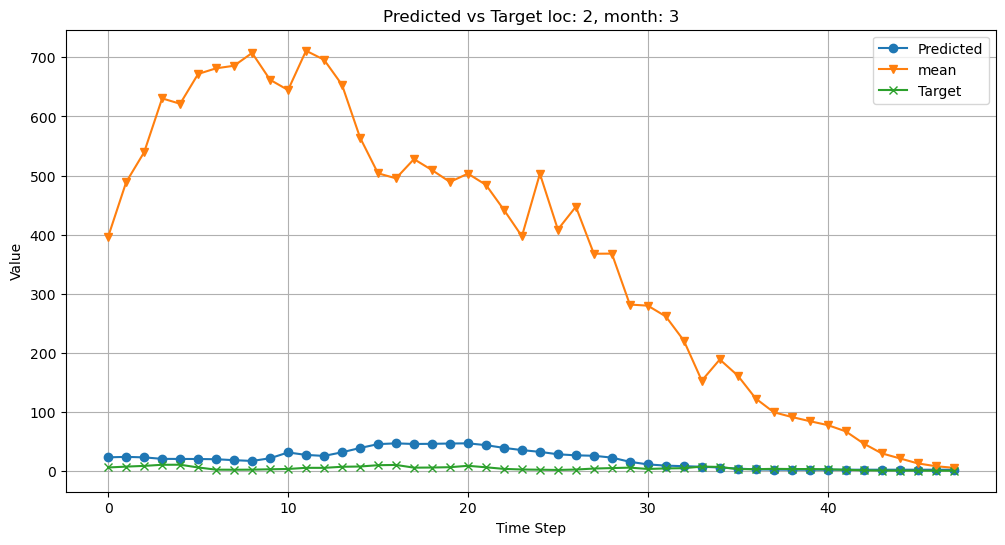

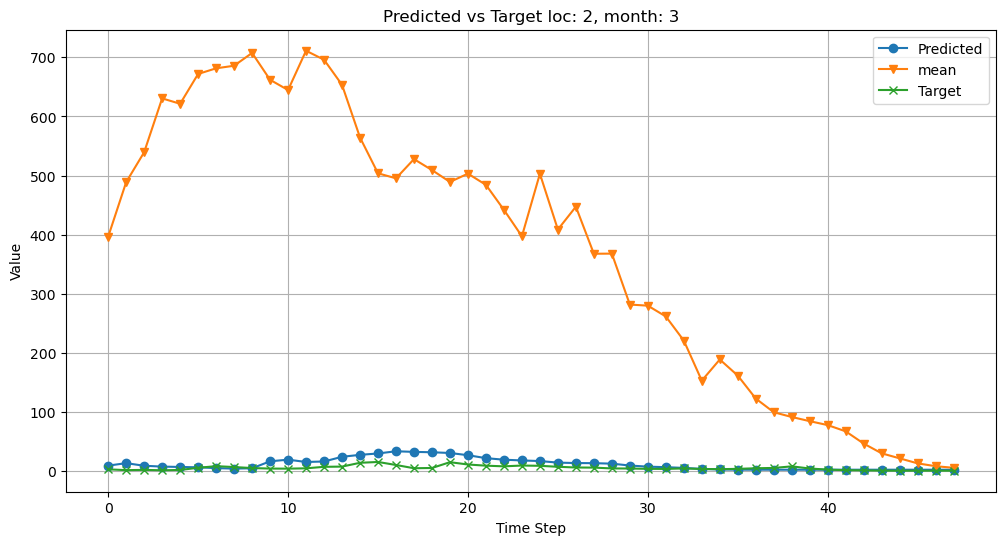

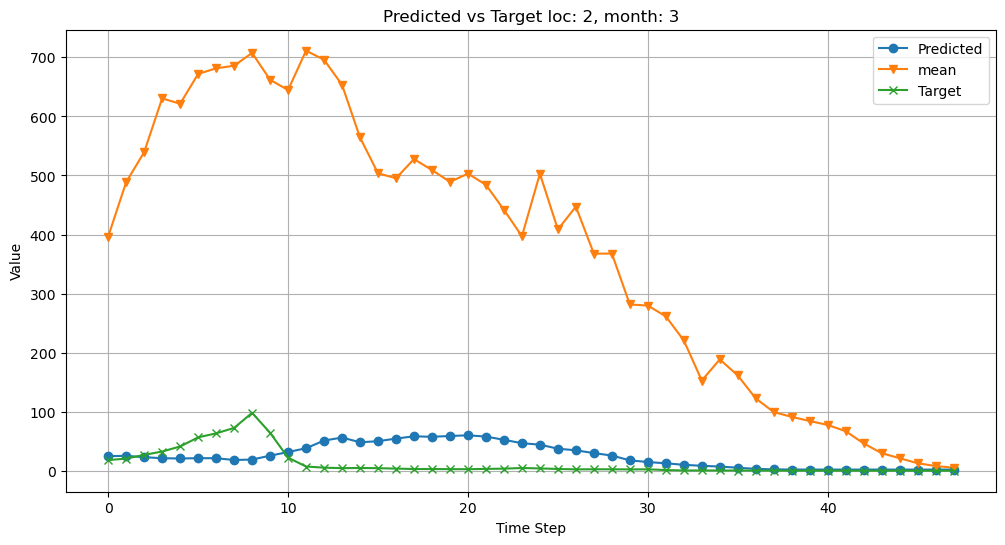

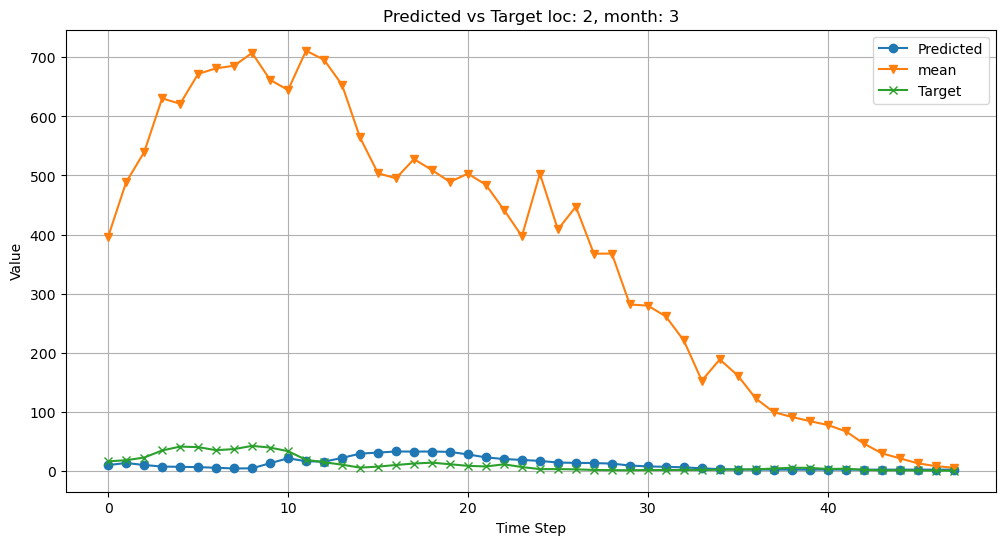

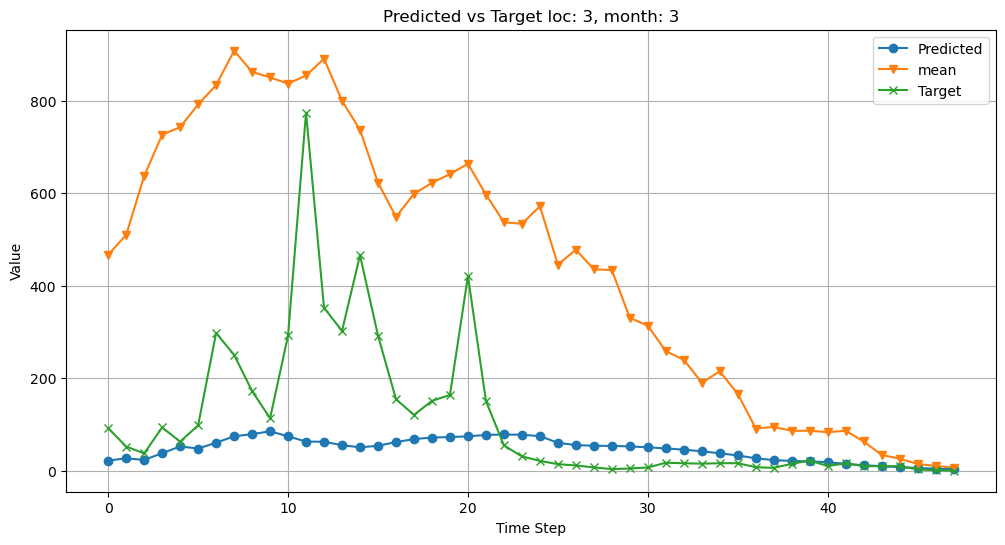

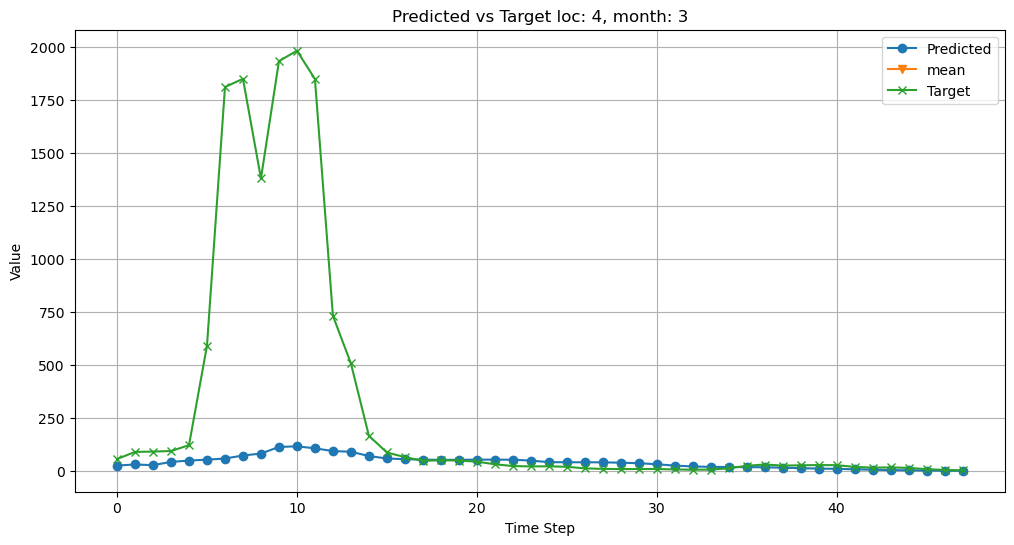

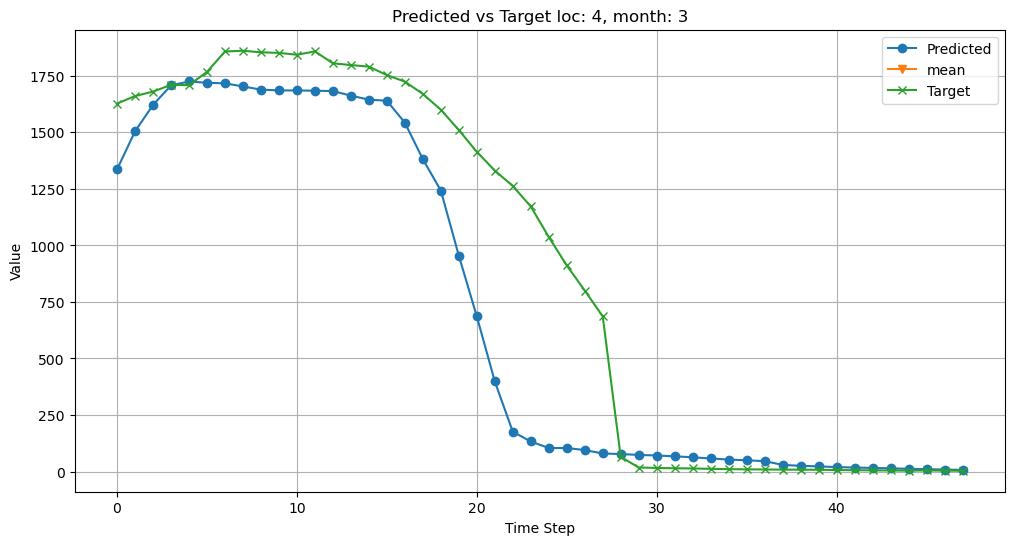

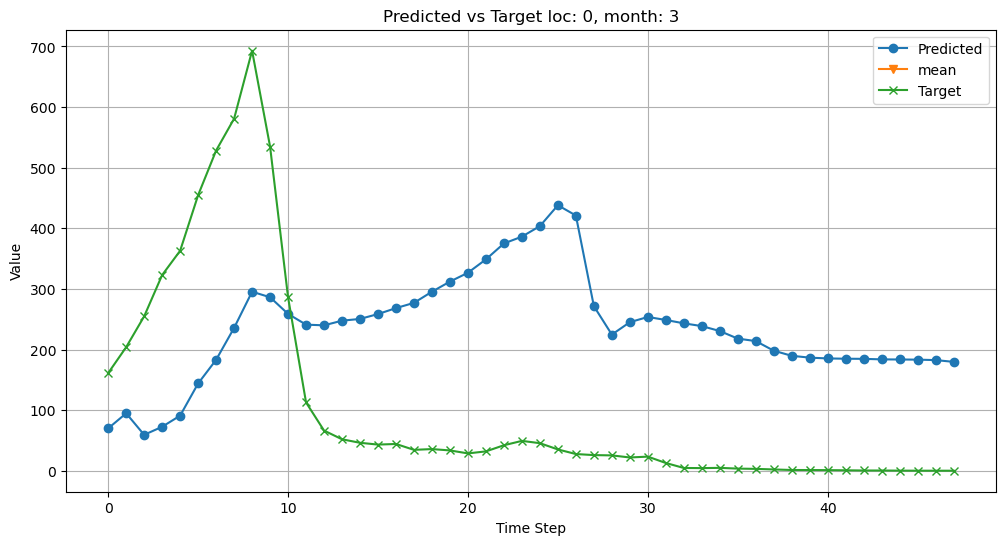

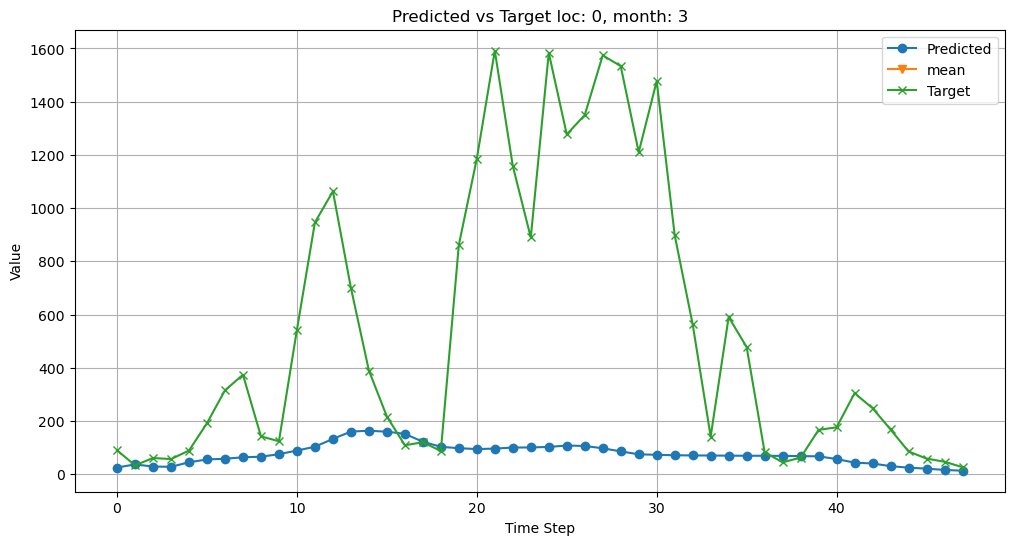

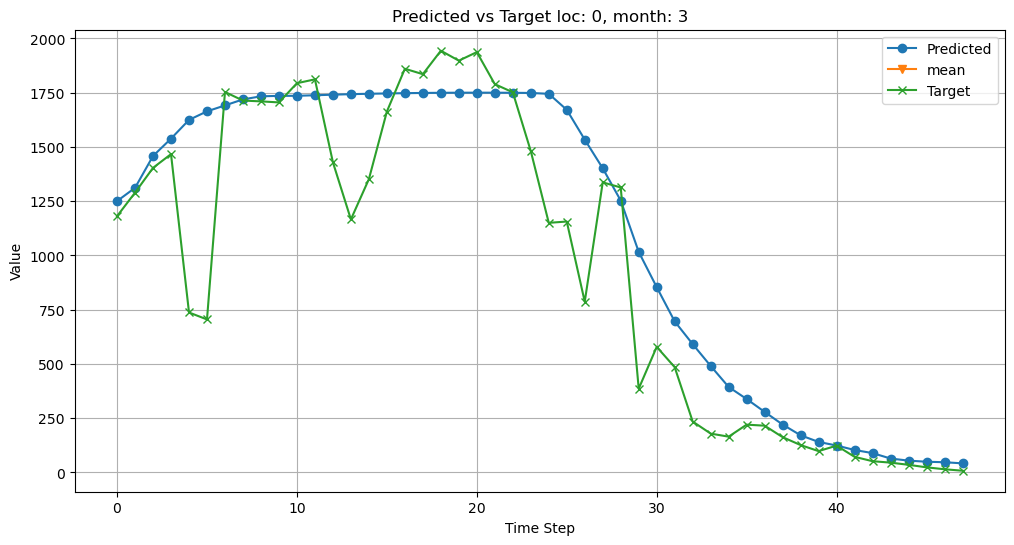

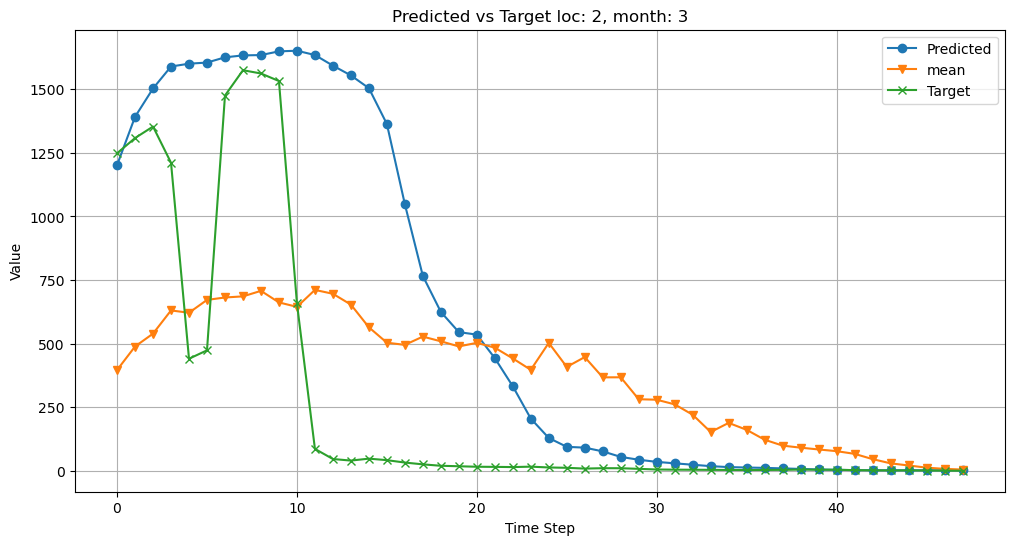

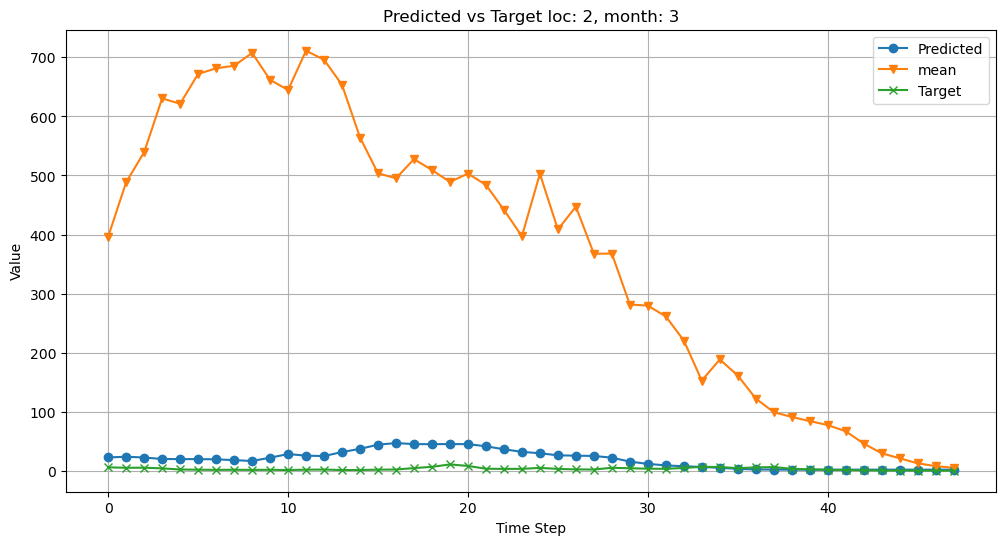

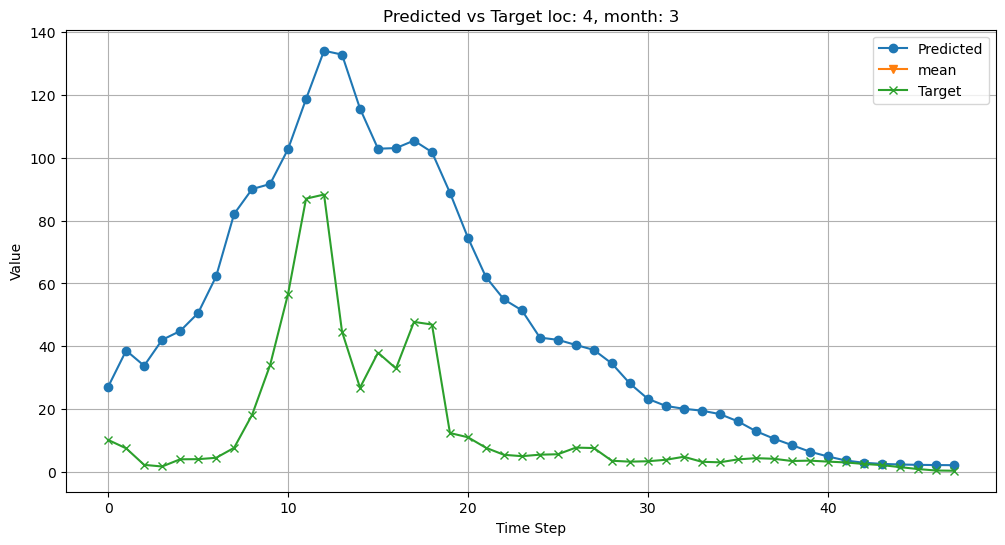

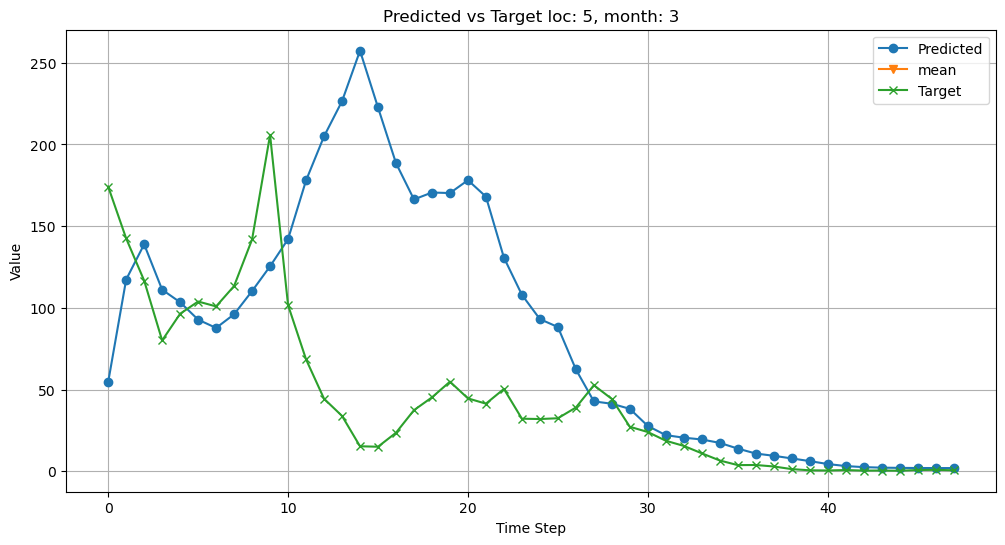

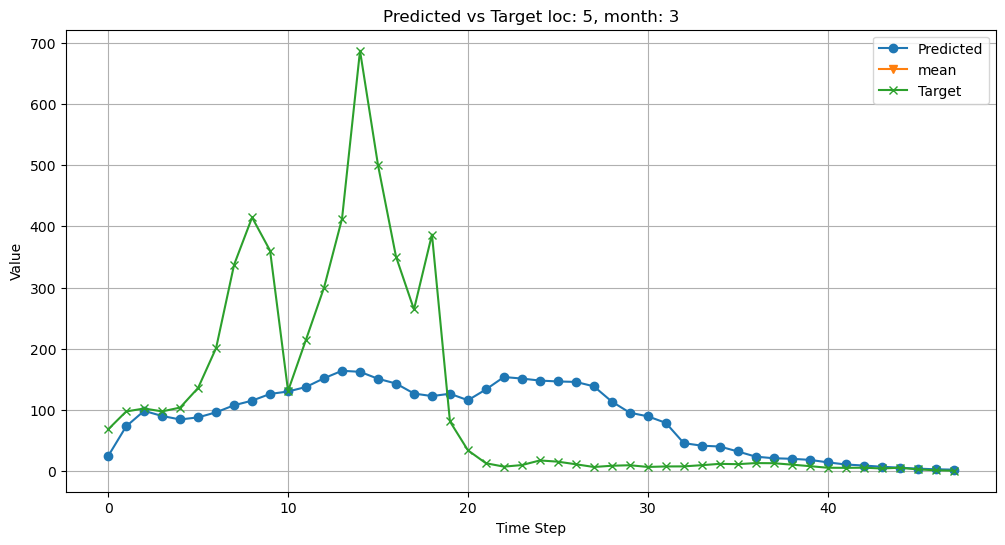

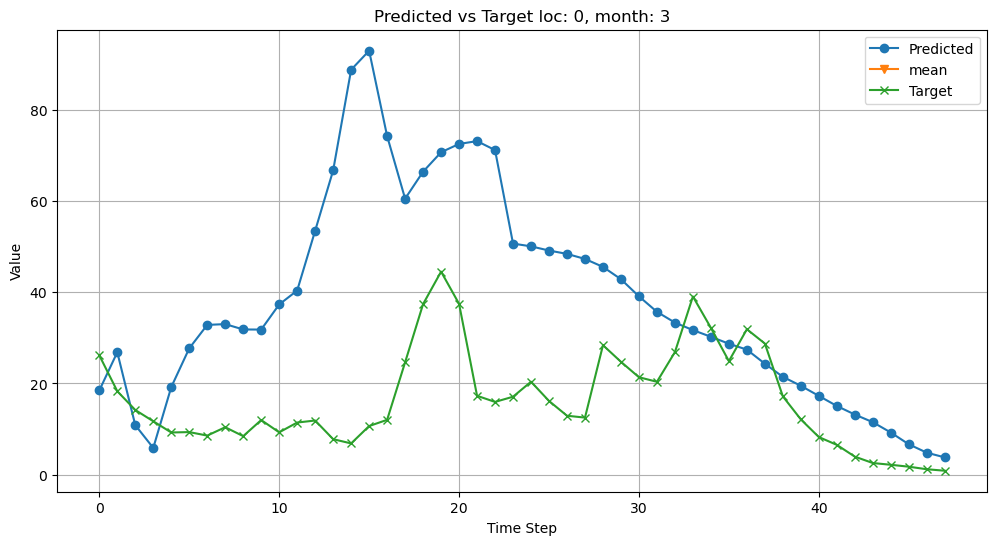

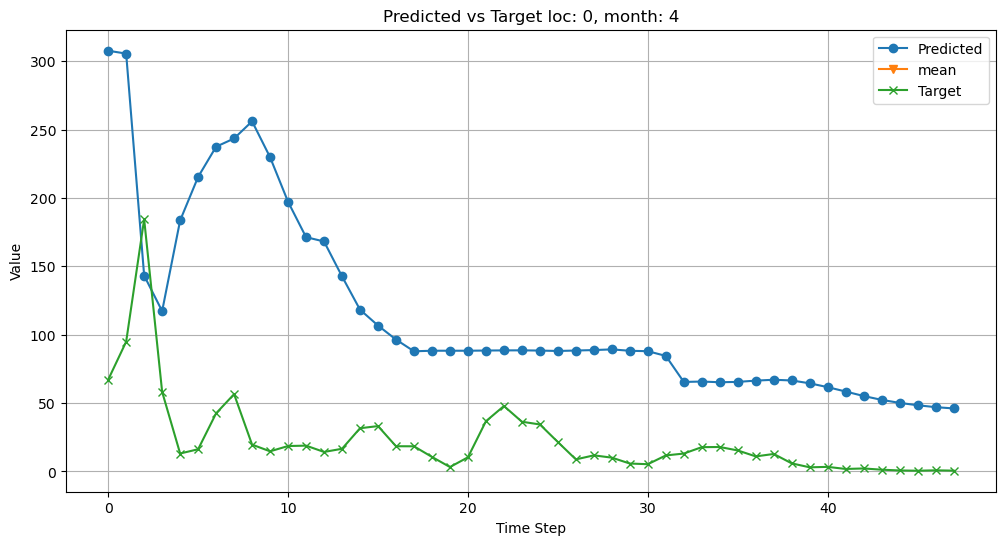

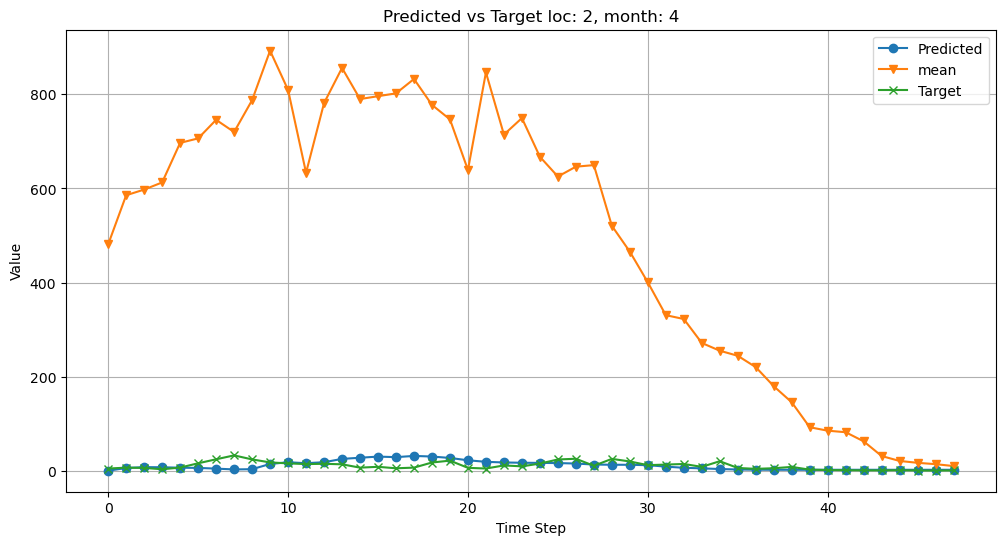

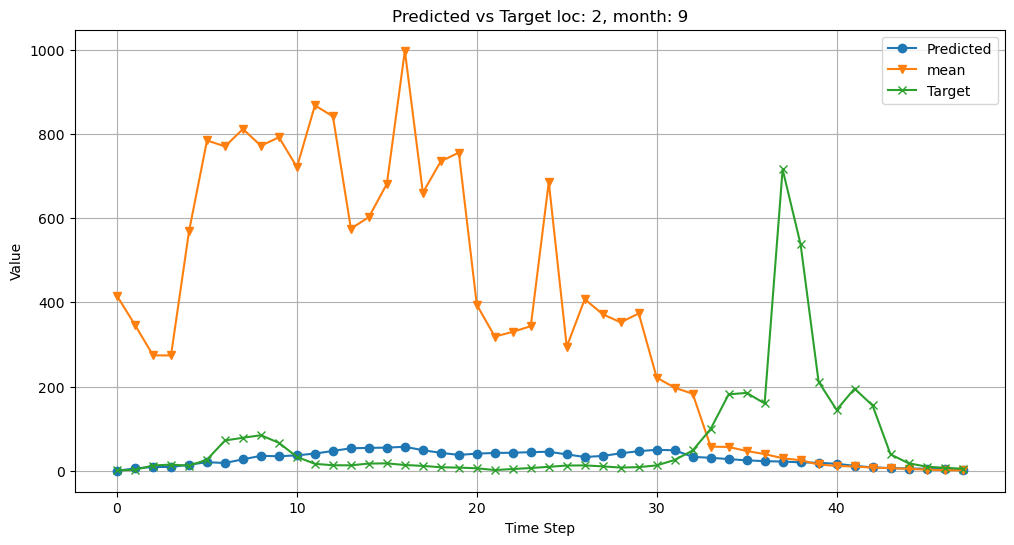

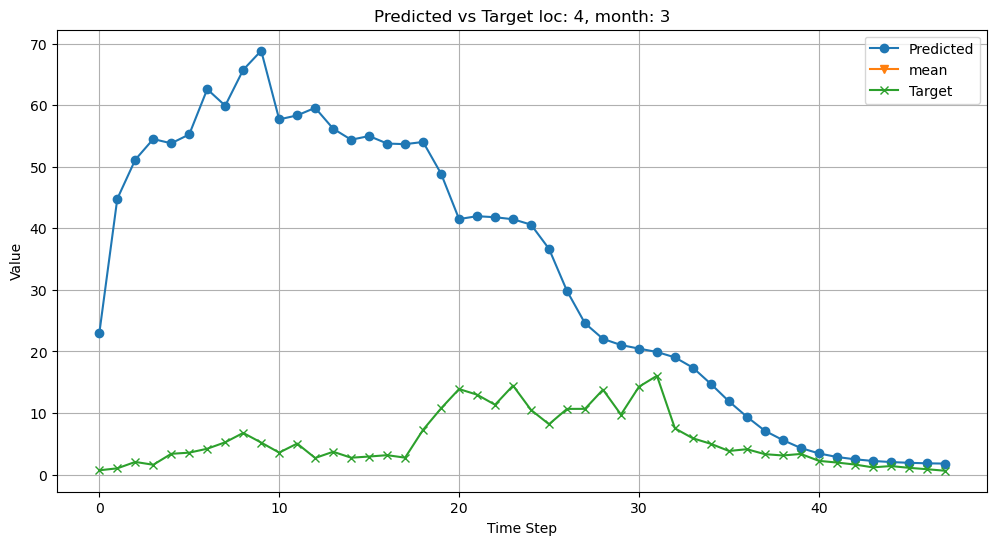

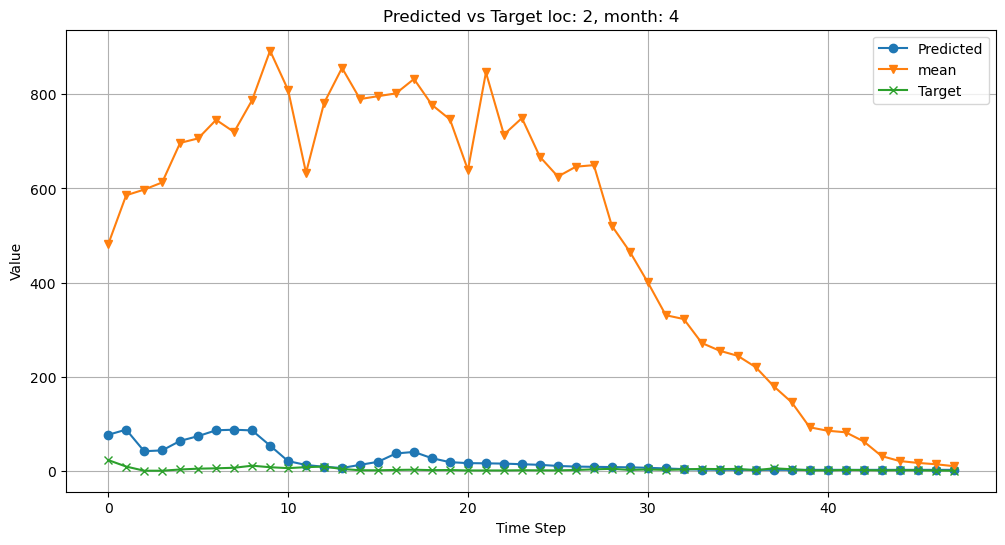

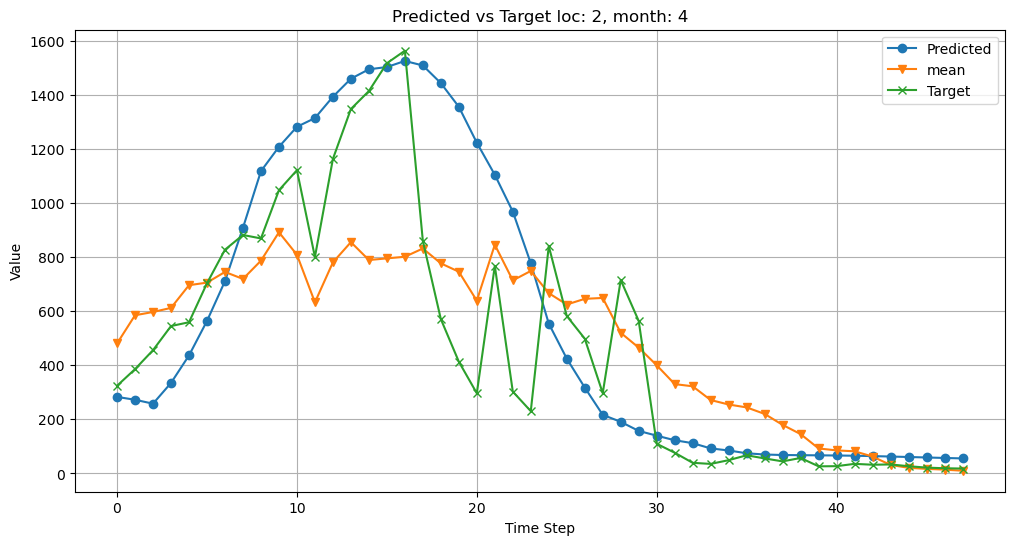

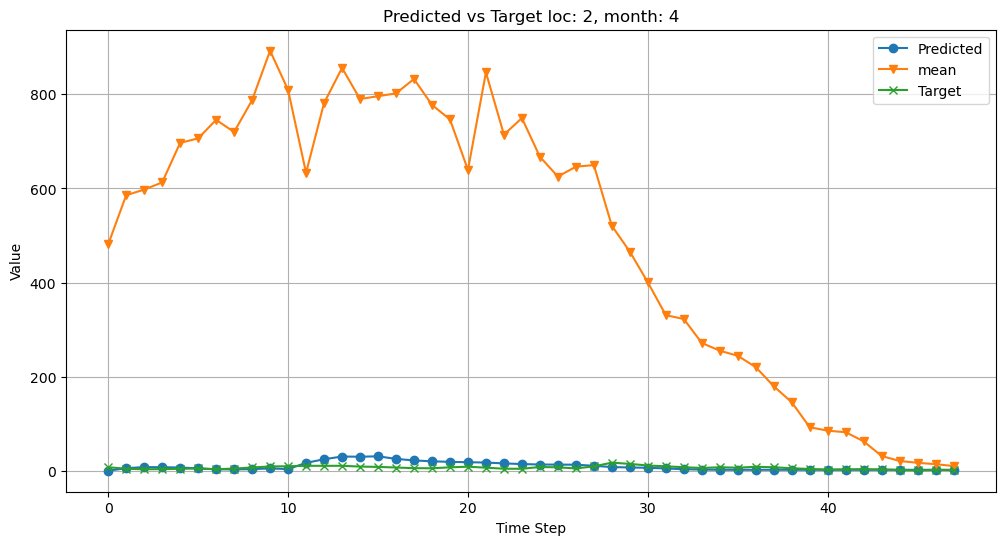

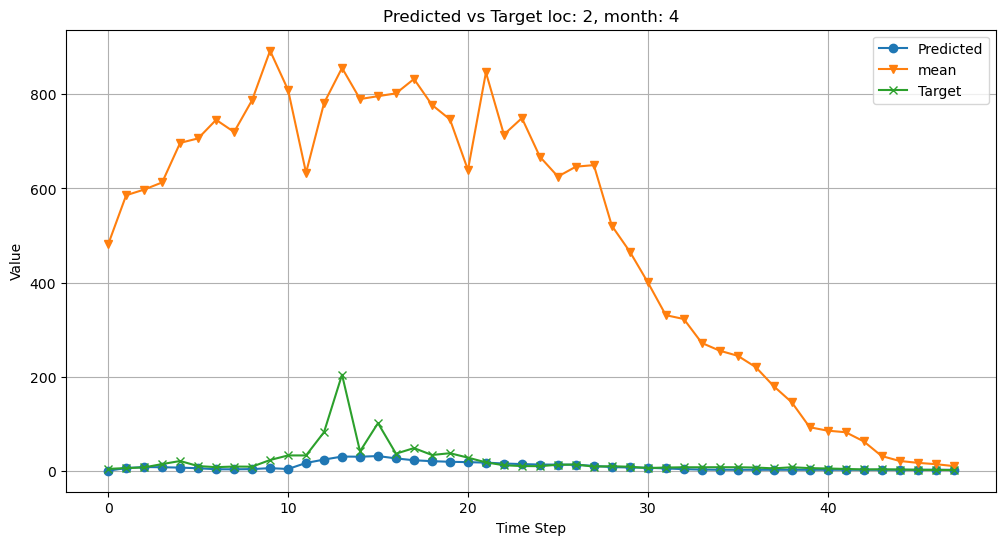

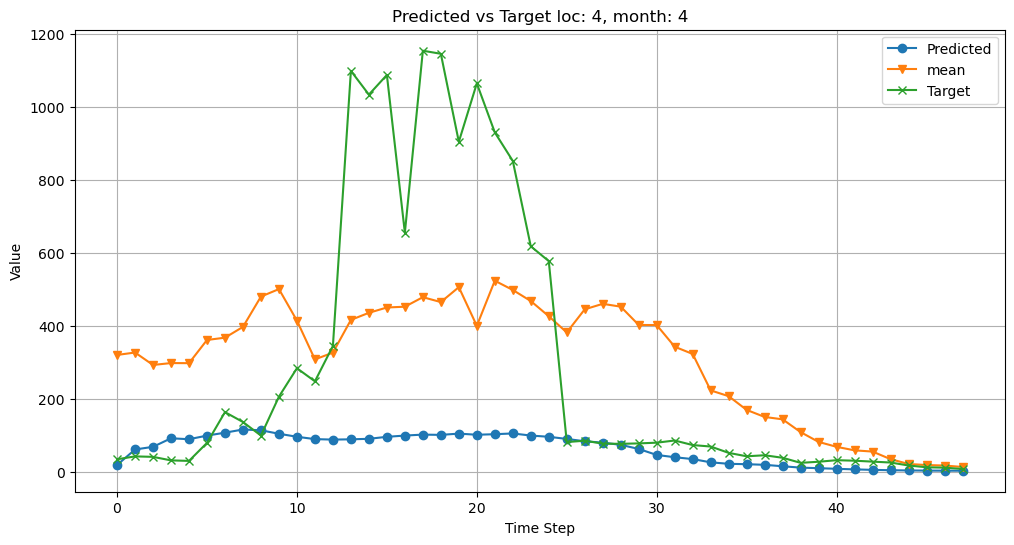

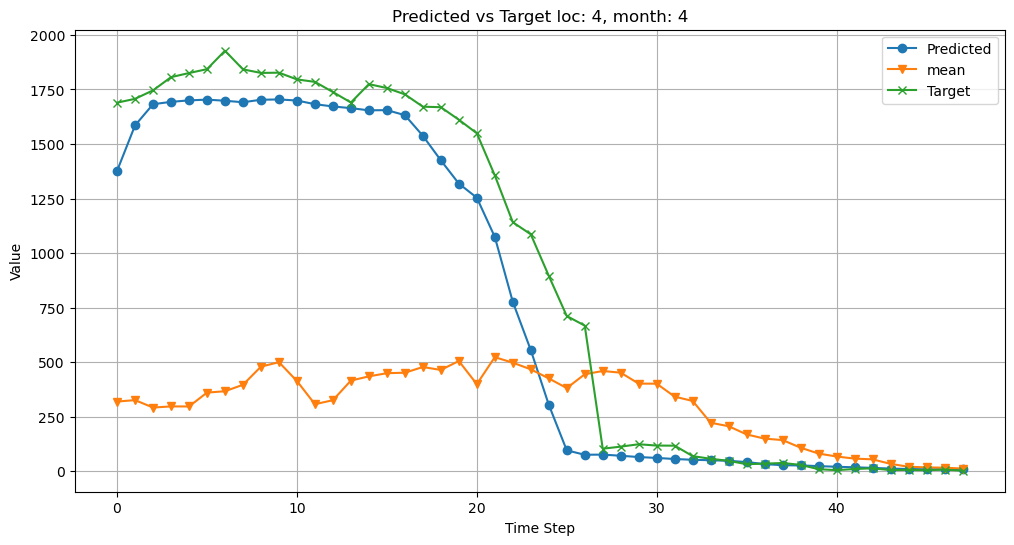

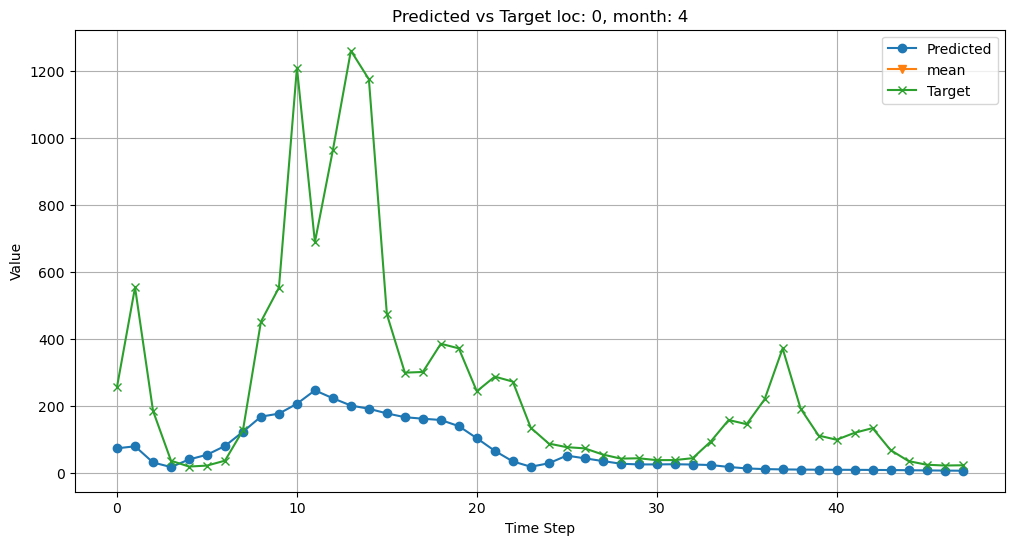

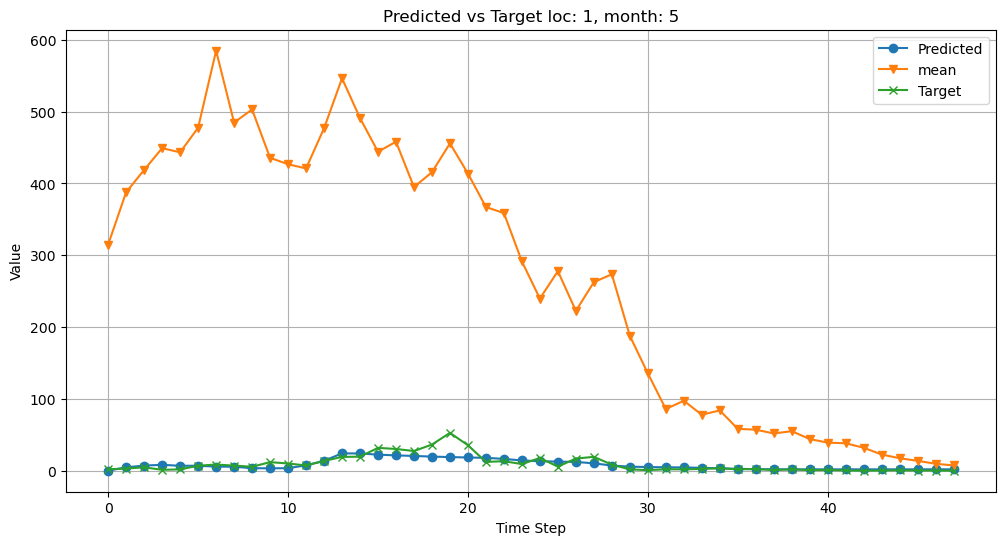

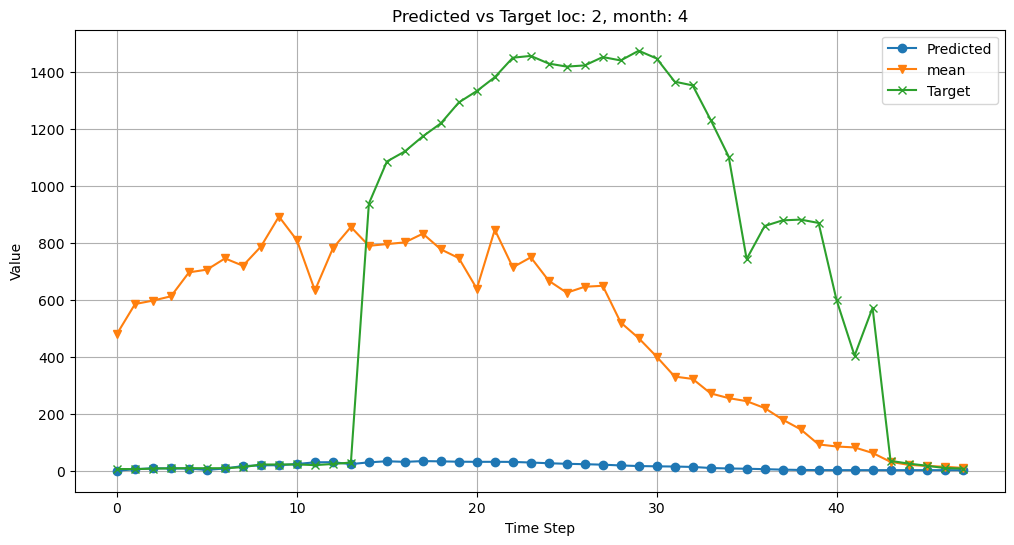

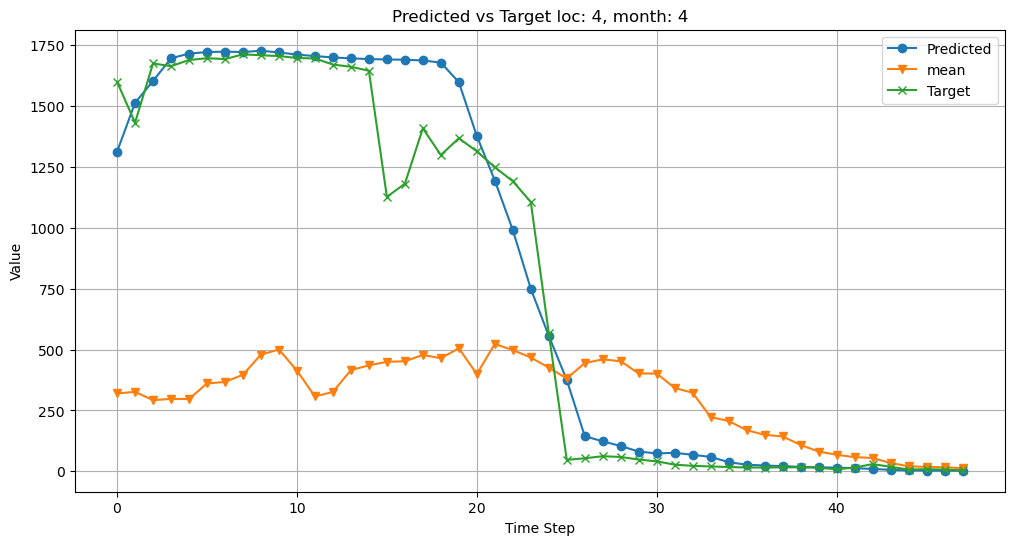

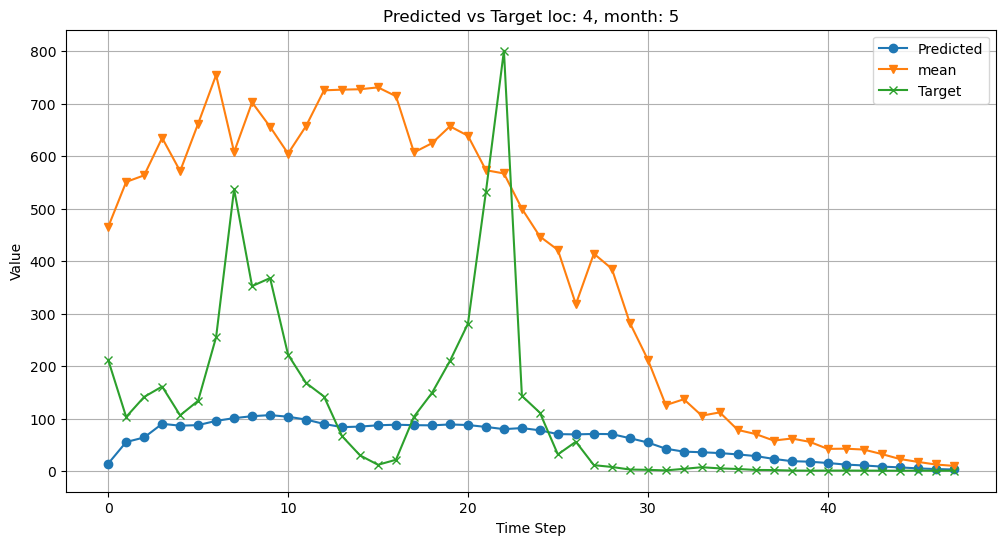

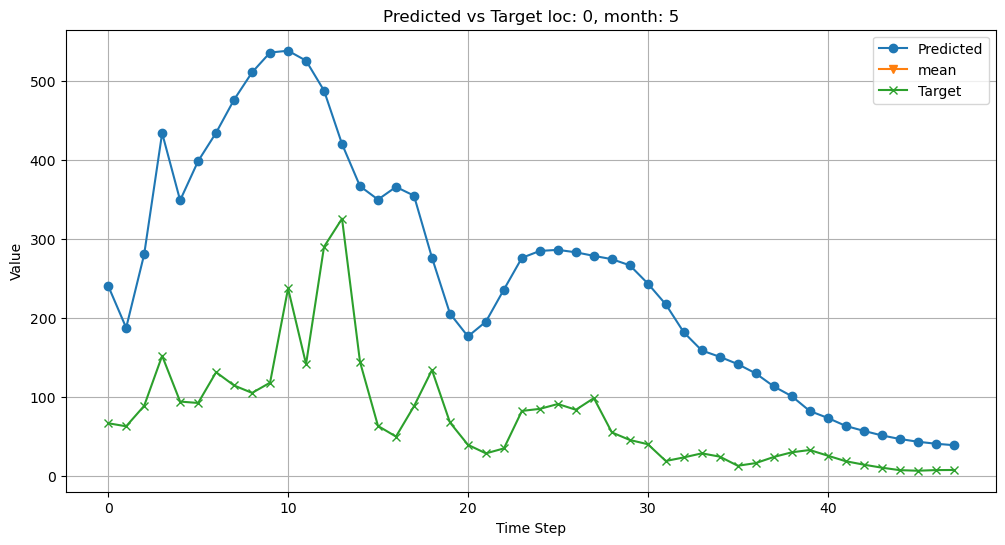

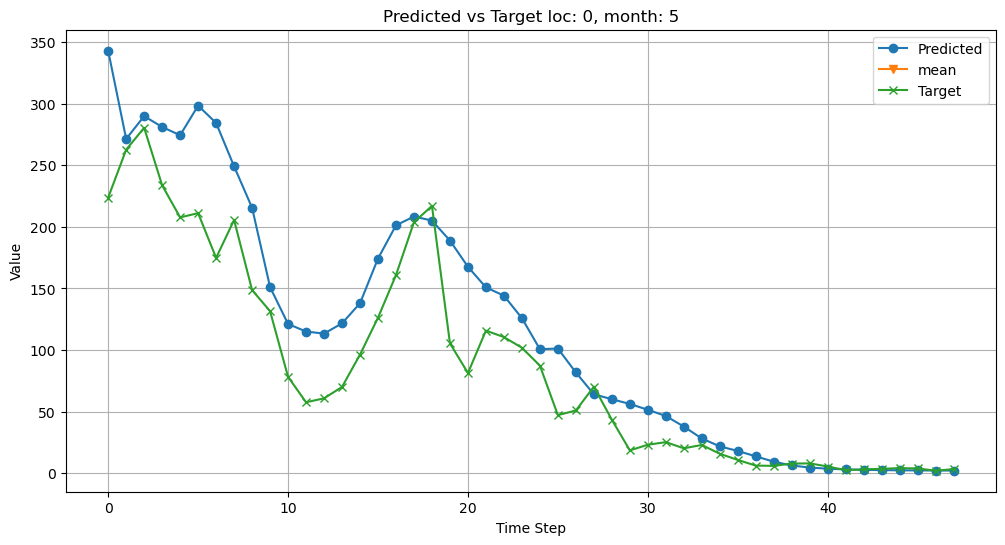

In [15]:
datas, support_datas, labels = valid_loader[0]

hidden = model.init_hidden(batch)
hidden = tuple([h.to(device, dtype=torch.float32) for h in hidden])

datas, support_datas, labels = datas.to('cuda', dtype=torch.float32), support_datas.to('cuda', dtype=torch.float32), labels.to('cuda', dtype=torch.float32)

predicted, _ = model(datas, support_datas, hidden)
predicted = predicted.detach().to('cpu').numpy().squeeze()
target = labels.to('cpu').numpy()


print(predicted.shape, target.shape)
print(support_datas.shape)

copy_target_df['hour_min'] = copy_target_df['DateTime'].dt.hour * 100 + copy_target_df['DateTime'].dt.minute

for predicted_plot, target_plot, support_data in zip(predicted, target, support_datas):
    location_code = int(support_data[0, 0])
    month  = int(support_data[0, 1] * 12)
    loc_df = copy_target_df[copy_target_df["LocationCode"] == location_code]
    loc_df = loc_df[loc_df["month"] == month]


    hour_group = loc_df.groupby('hour_min').mean().reset_index()

    

    hour_9_17 = hour_group[hour_group['hour'] < 17]
    hour_9_17 = hour_9_17[hour_9_17['hour'] >= 9]
    hour_9_17_plot = list(hour_9_17['Power(mW)'])
    # 繪製折線圖
    plt.figure(figsize=(12, 6))
    plt.plot(predicted_plot, label='Predicted', marker='o')
    plt.plot(hour_9_17_plot, label='mean', marker='v')
    plt.plot(target_plot, label='Target', marker='x')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.title(f'Predicted vs Target loc: {location_code}, month: {month}')
    plt.legend()
    plt.grid()
    plt.show()


In [16]:
#取得上傳用資料
upload, upload_target_list = get_upload_target_list()
upload_data_batch, upload_support_data_batch = get_upload_data_list(target_df, upload_target_list)

upload_loader = list(zip(upload_data_batch, upload_support_data_batch))

In [17]:
min_num, max_num = 1e9, 0

for data in upload_data_batch:
    min_num = min(len(data), min_num)
    max_num = max(len(data), max_num)
print(min_num, max_num)

15 24


In [18]:


model.eval()
ans = []
with torch.no_grad():
    for datas, support_datas in upload_loader:
        # 將輸入和標籤移到 GPU
        datas, support_datas = datas.to(device, dtype=torch.float32), support_datas.to(device, dtype=torch.float)
        datas = datas.view(1, -1, datas.shape[1])
        support_datas = support_datas.view(1, -1, support_datas.shape[1])
        # 初始化隱藏狀態
        hidden = model.init_hidden(batch_size=datas.size(0))
        hidden = tuple([h.to(device, dtype=torch.float32) for h in hidden])

        # 前向傳播
        outputs, _ = model(datas, support_datas, hidden)

        outputs = outputs.to('cpu', dtype=torch.float32)
        ans.extend(outputs.view(-1).tolist())



        

In [19]:
upload['答案'] = np.array(ans)
upload.to_csv('try.csv', index=False)